# 心拍計測したときどれだけ綺麗か（SNR）
データ：20211118_dataに保管
- 廊下、三脚　50cm,75cm,1m
- 対照実験　有線vsbluetooth

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import codecs
import os
import re
from tqdm import tqdm

# CWT
import math
import pycwt

# 自作関数
import sys
sys.path.append('..')
import sig_proc
peak_detect = __import__('2_peak_detect') # 先頭が数字のファイルなので素直にimportできない　非推奨だがこのやり方ならOK

67.7262742772967


<ipython-input-20-3a269884f34d>:84: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()
<ipython-input-20-3a269884f34d>:178: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


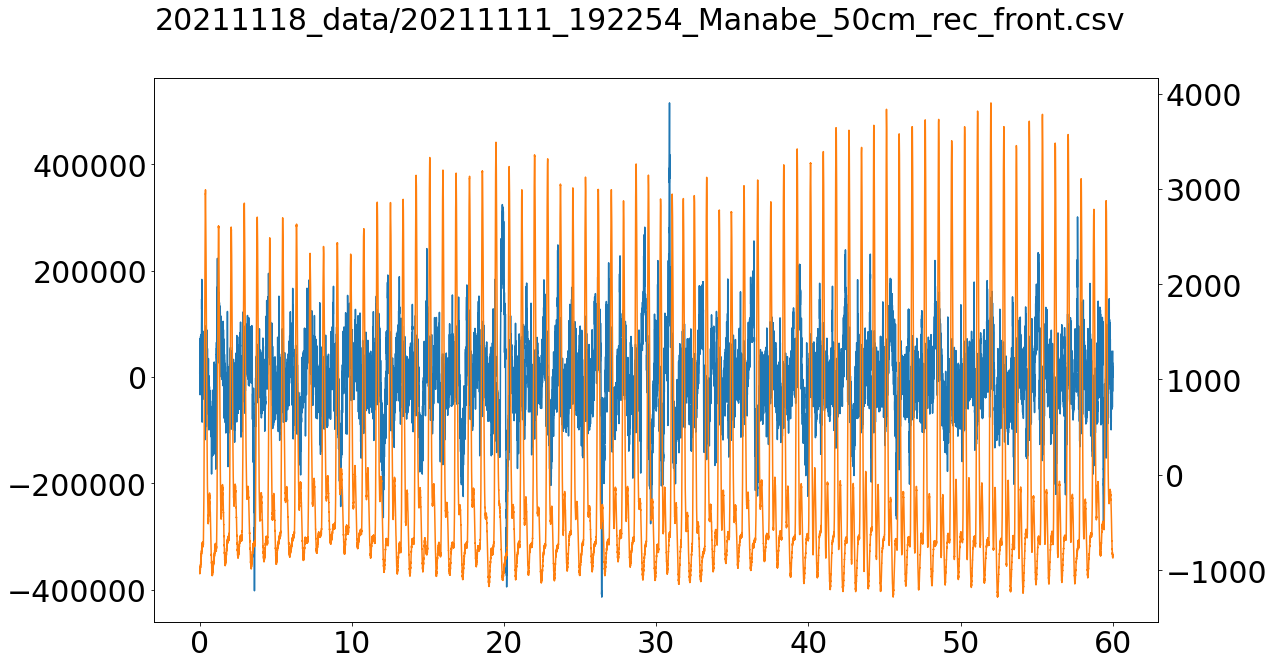

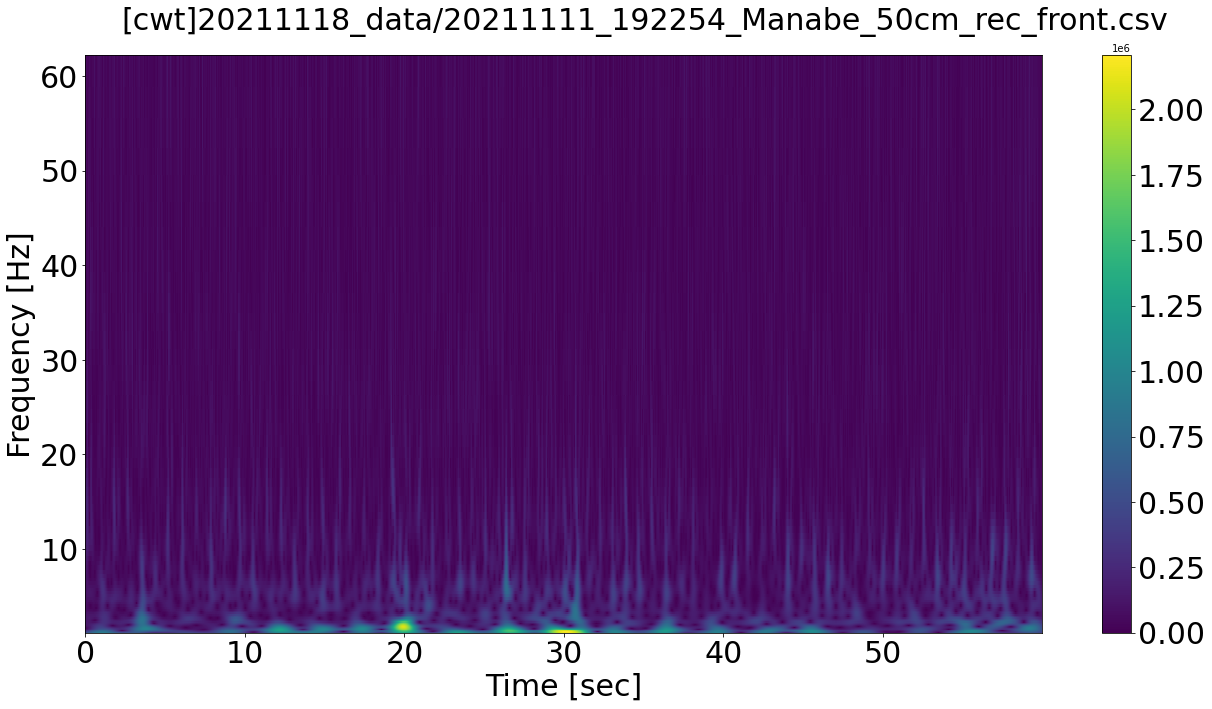

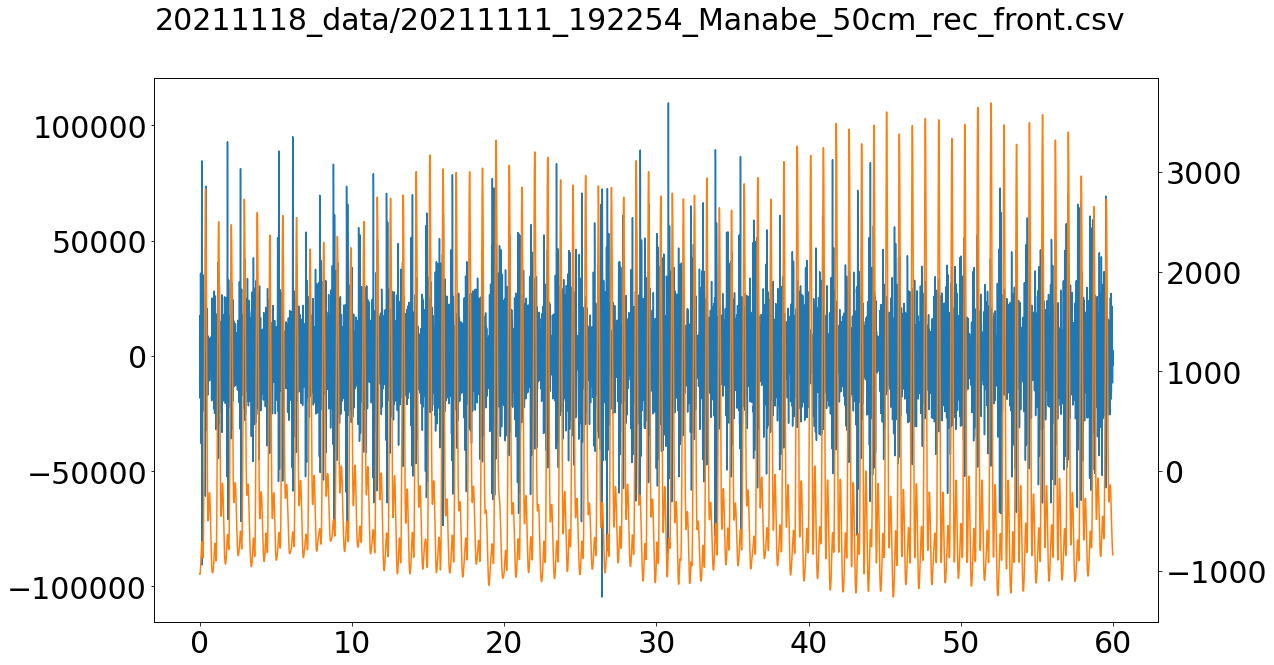

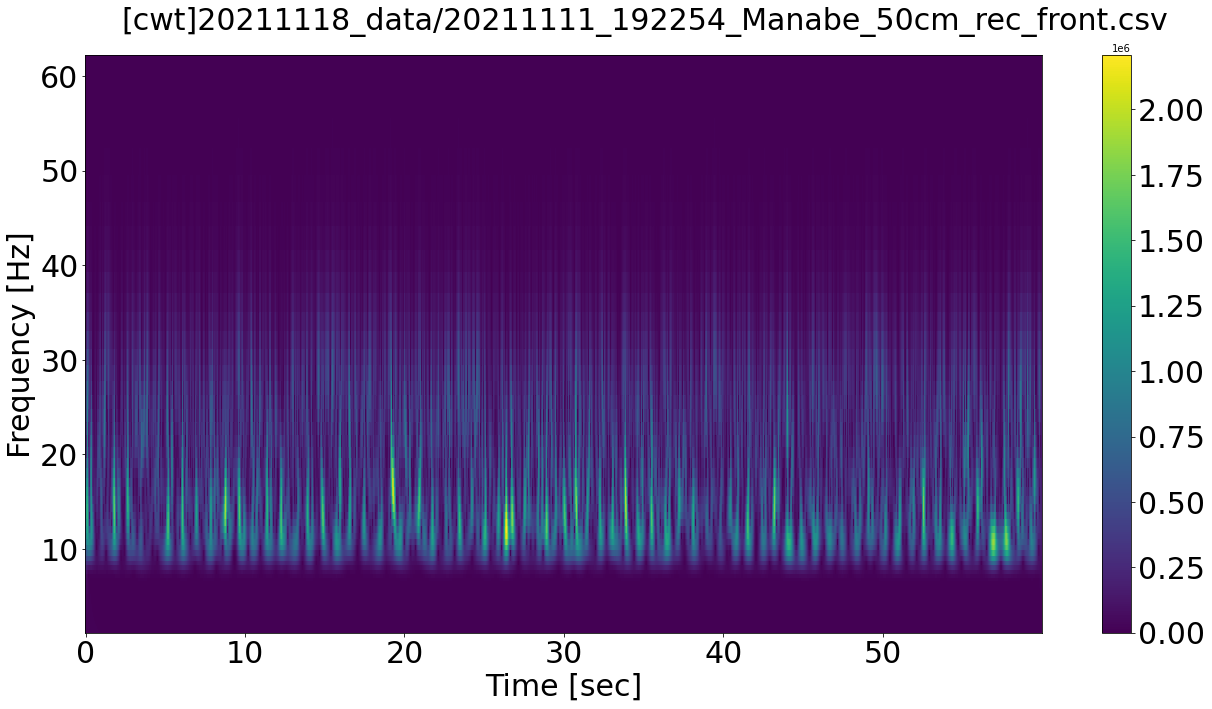

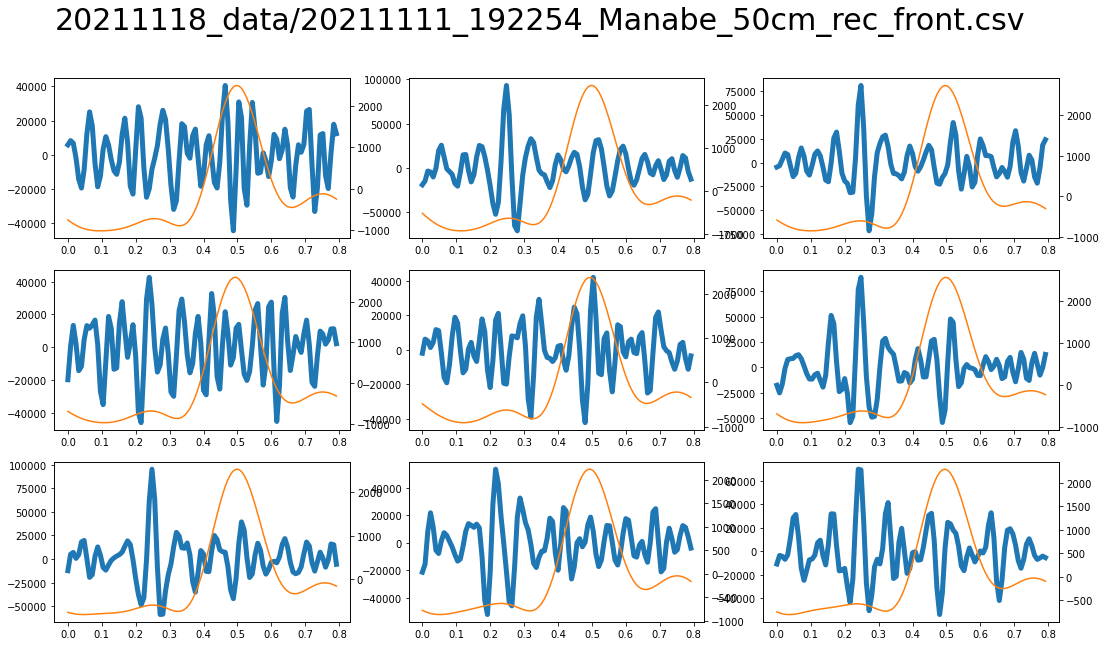

<ipython-input-20-3a269884f34d>:84: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()
<ipython-input-20-3a269884f34d>:178: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


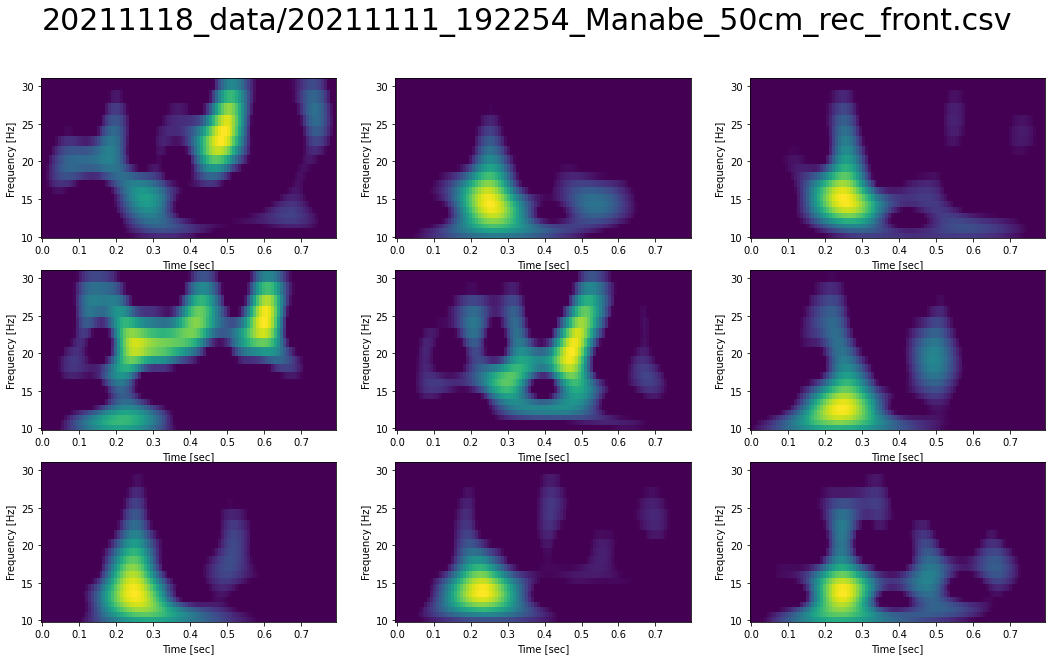

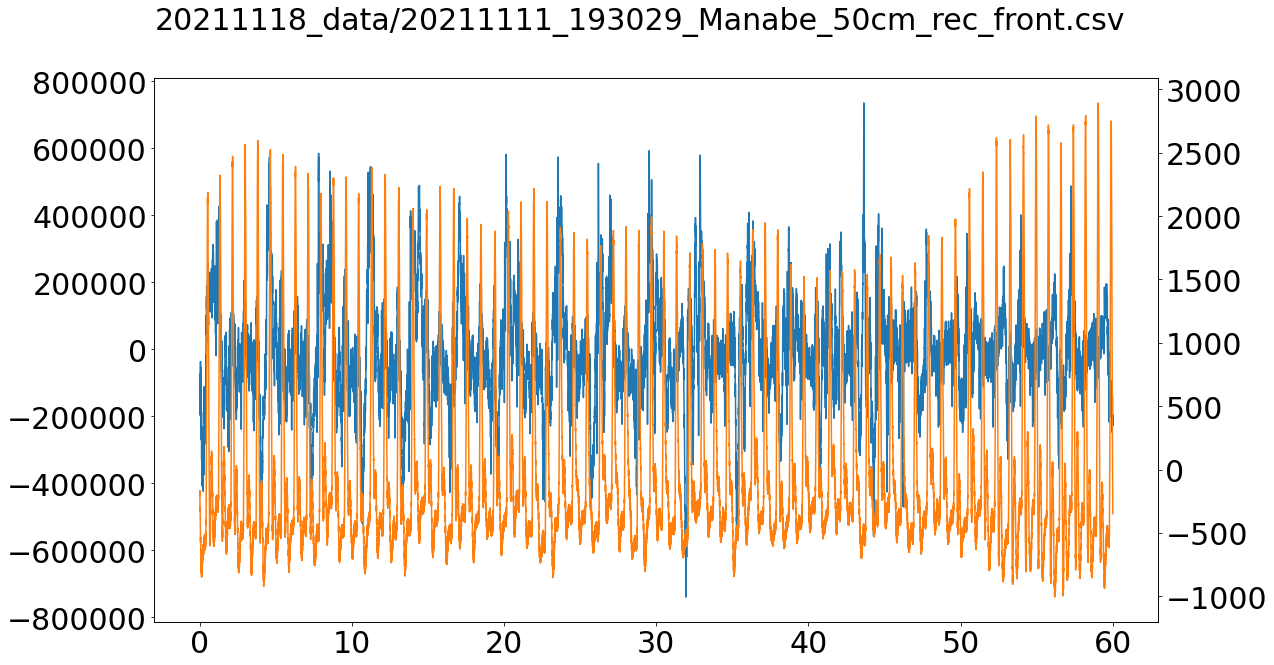

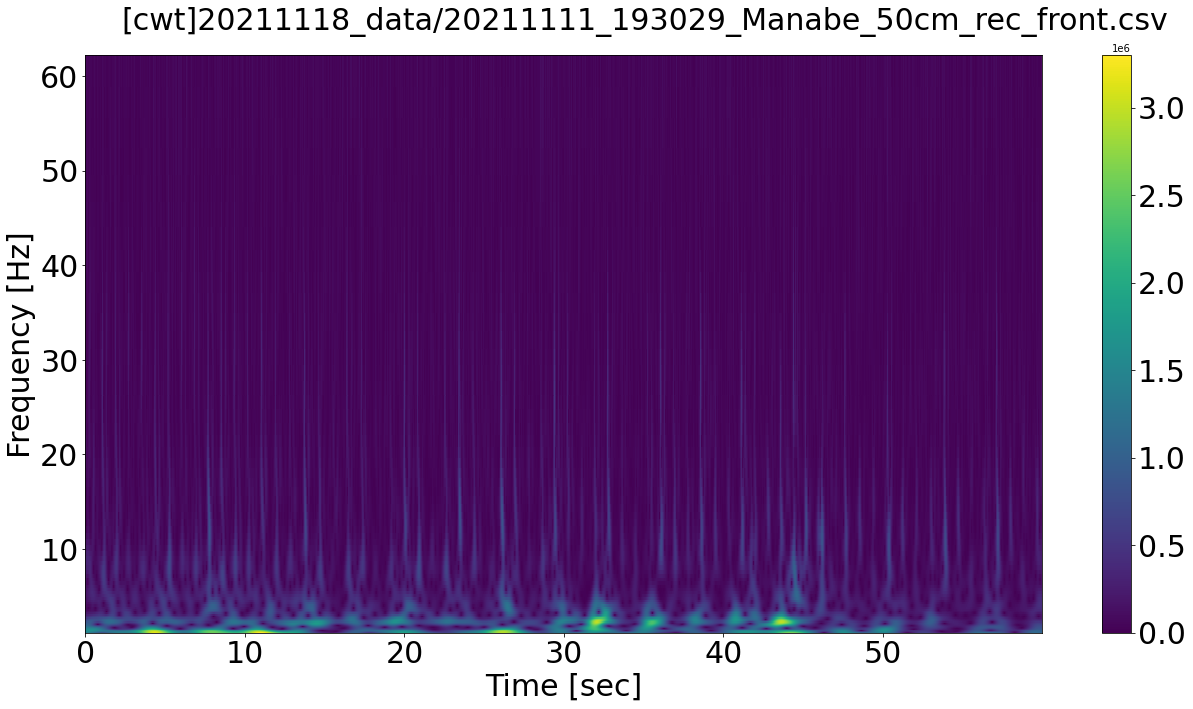

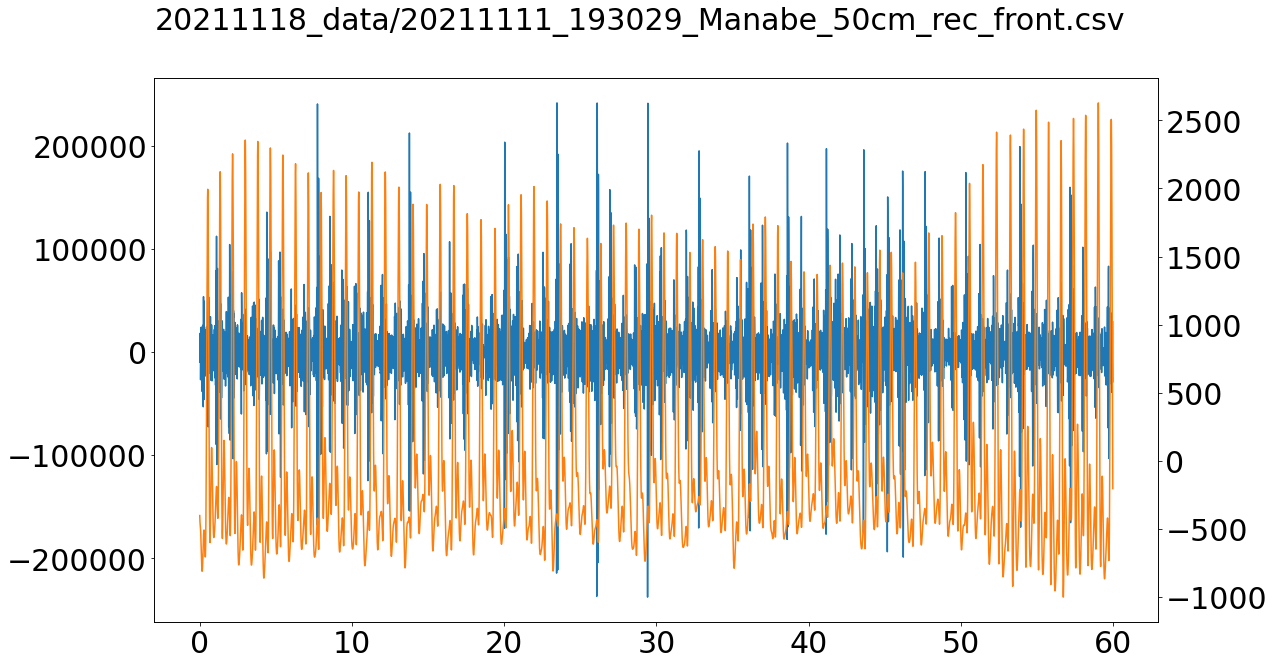

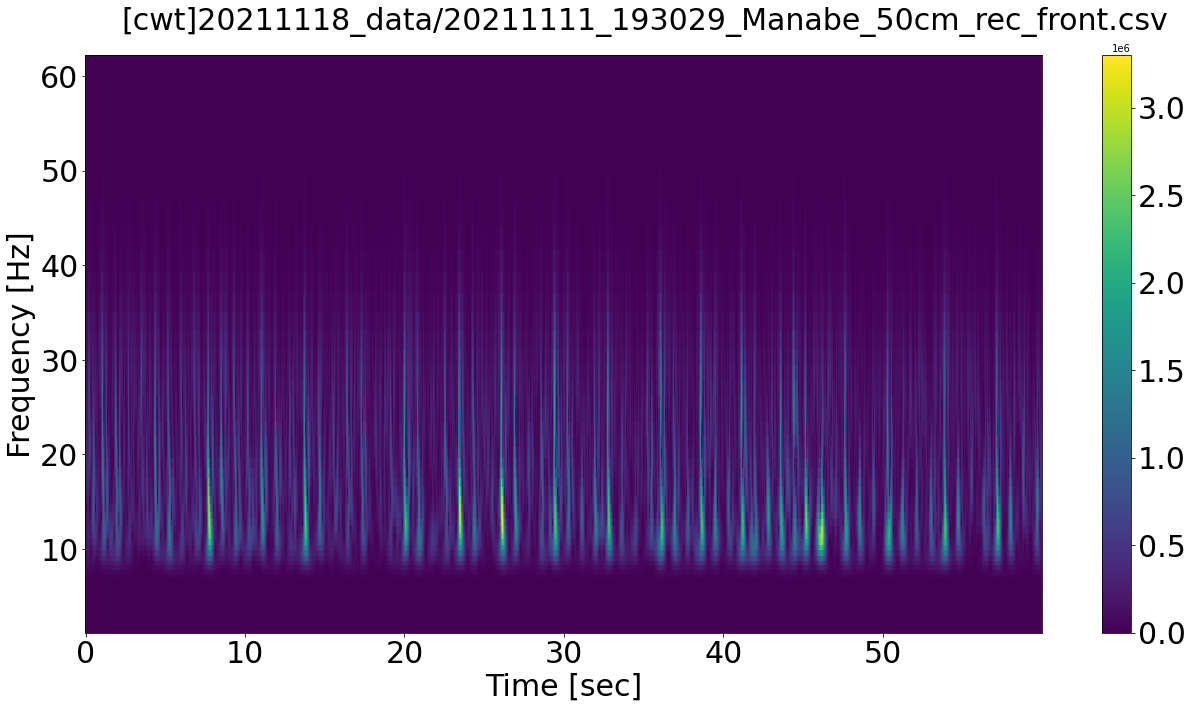

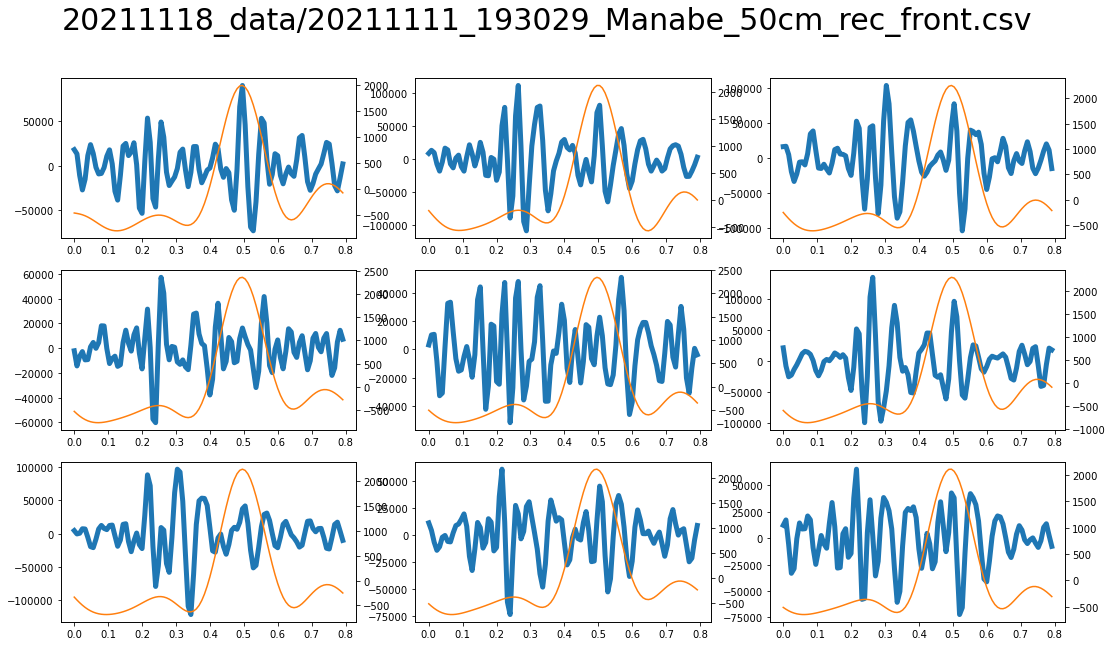

<ipython-input-20-3a269884f34d>:84: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()
<ipython-input-20-3a269884f34d>:178: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


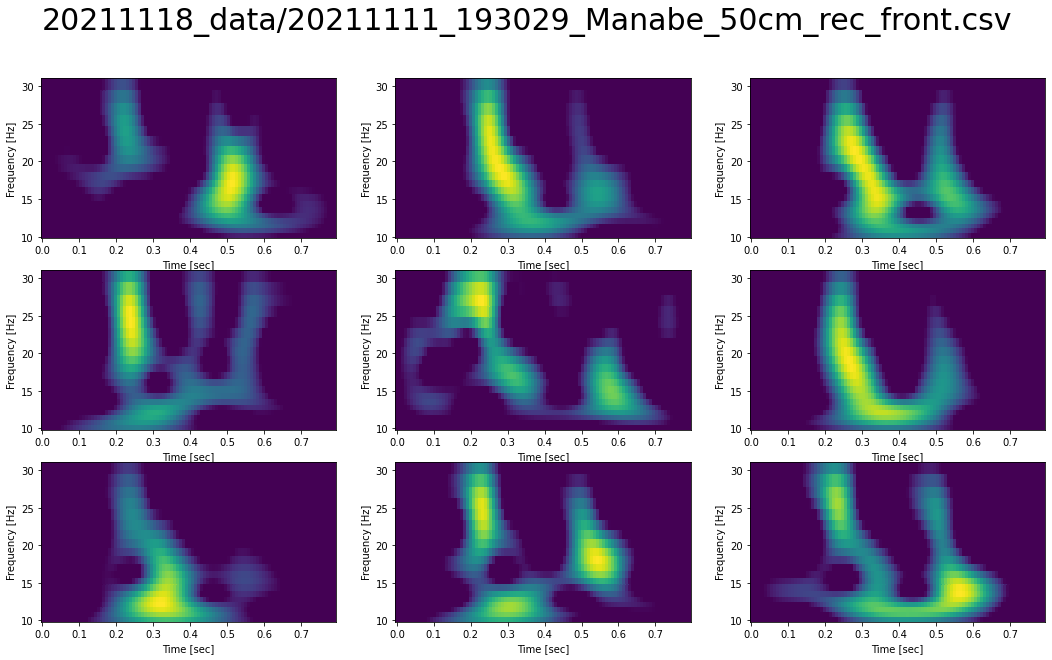

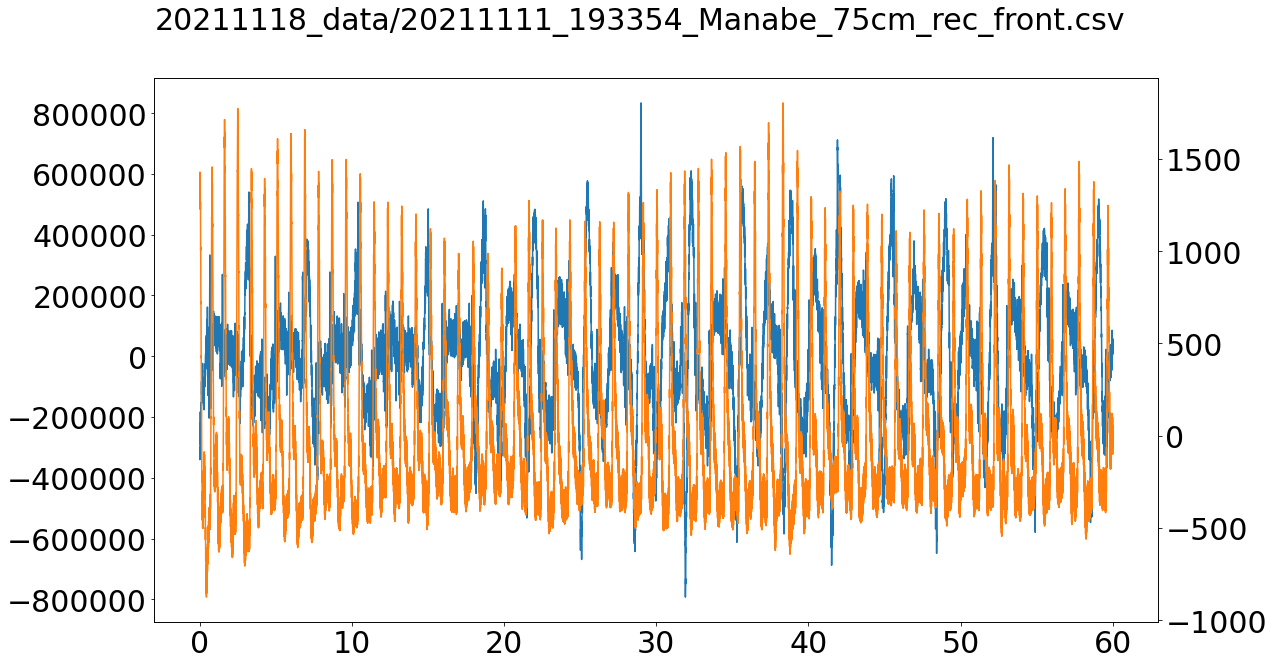

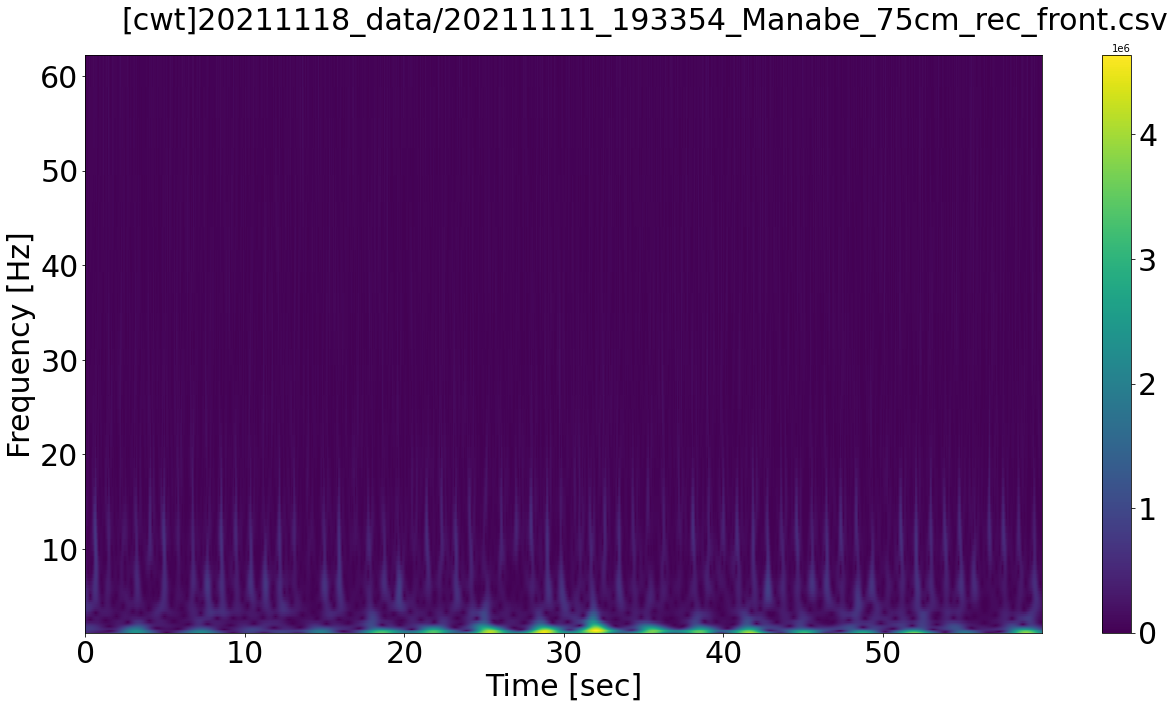

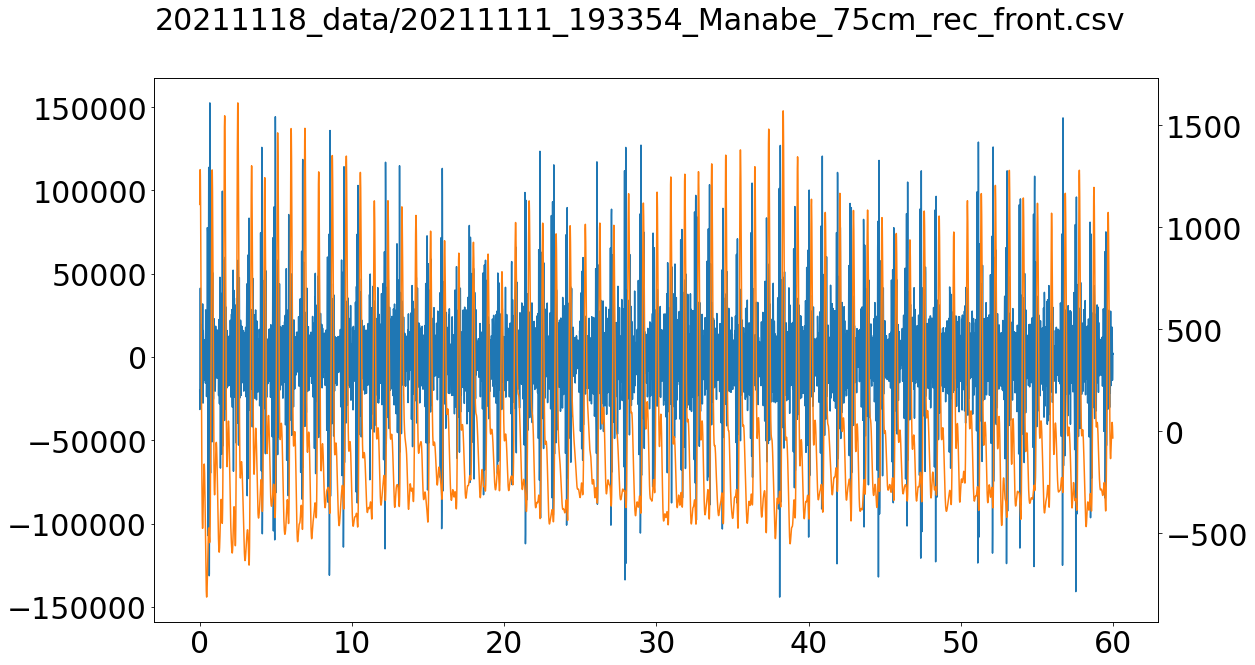

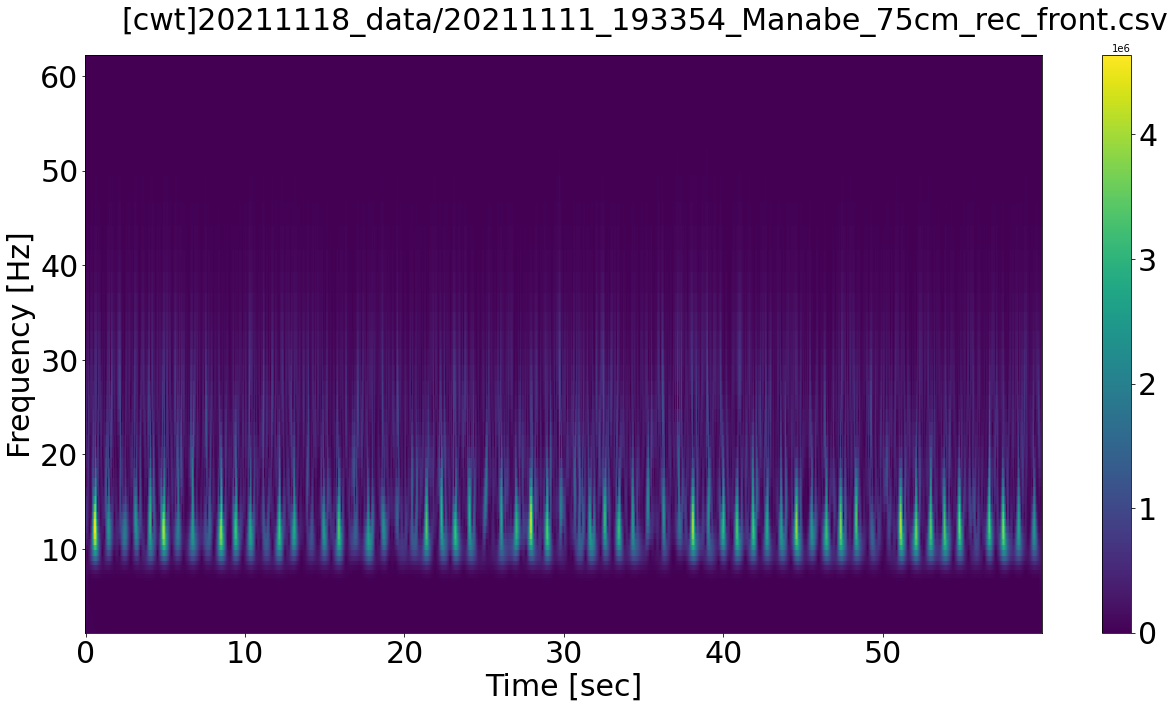

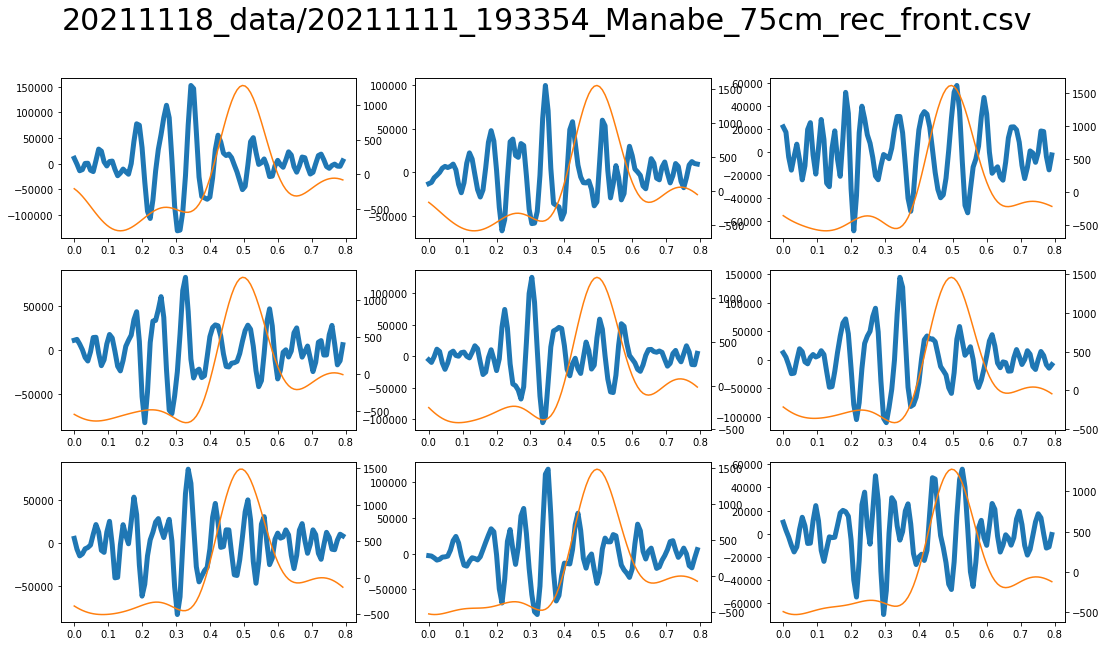

<ipython-input-20-3a269884f34d>:84: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()
<ipython-input-20-3a269884f34d>:178: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


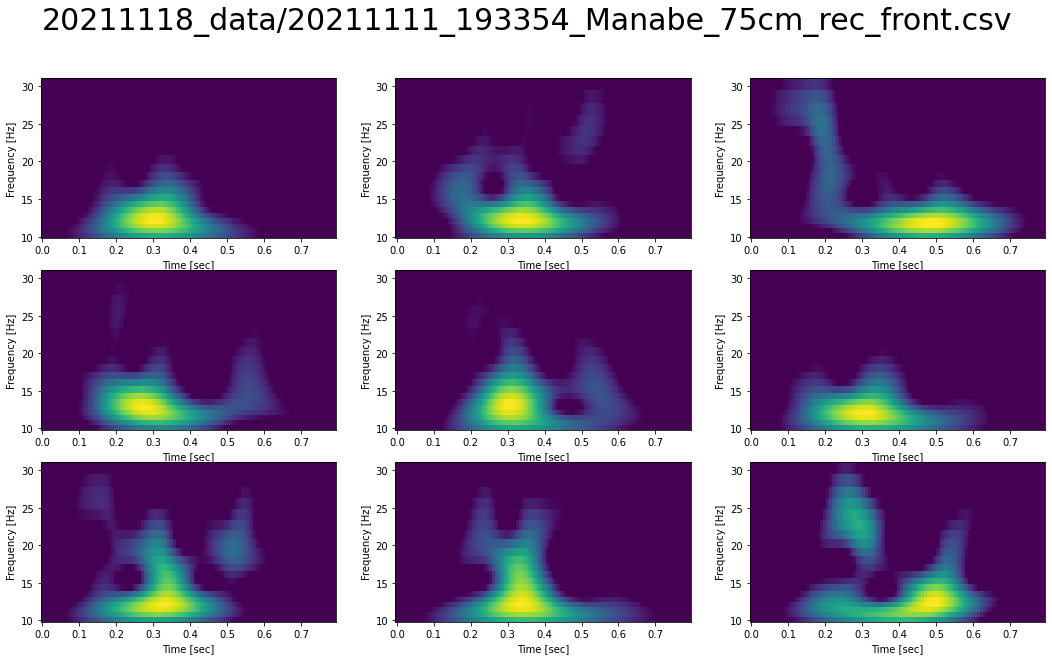

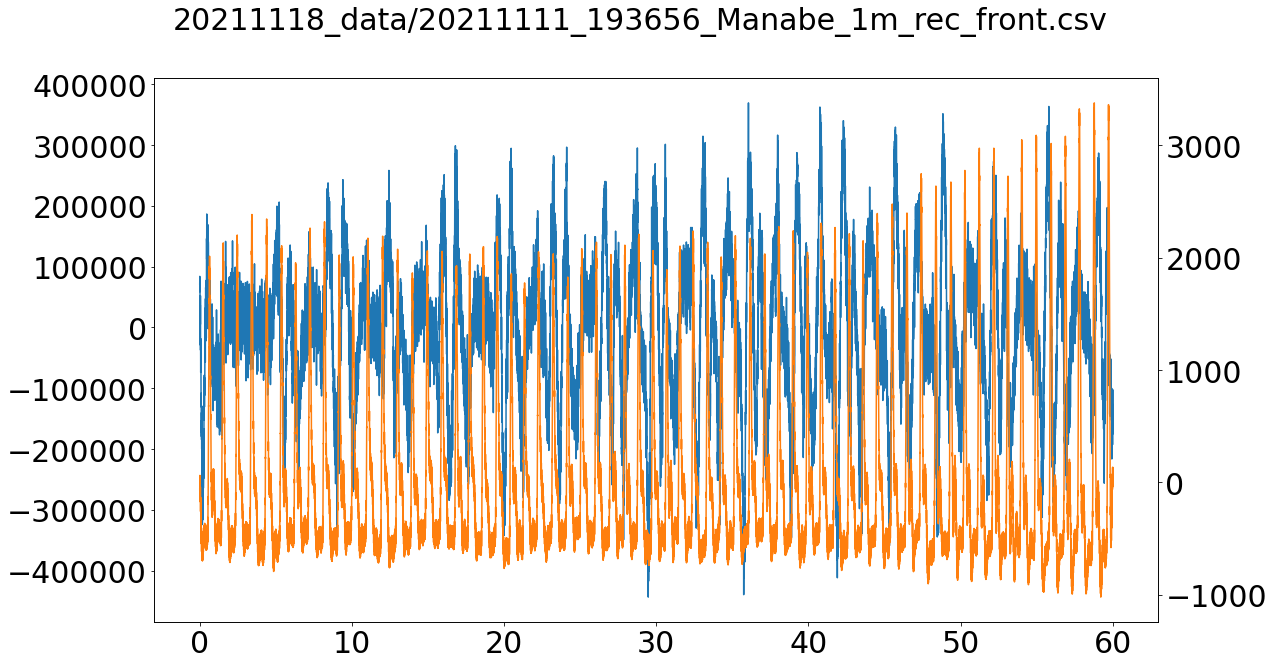

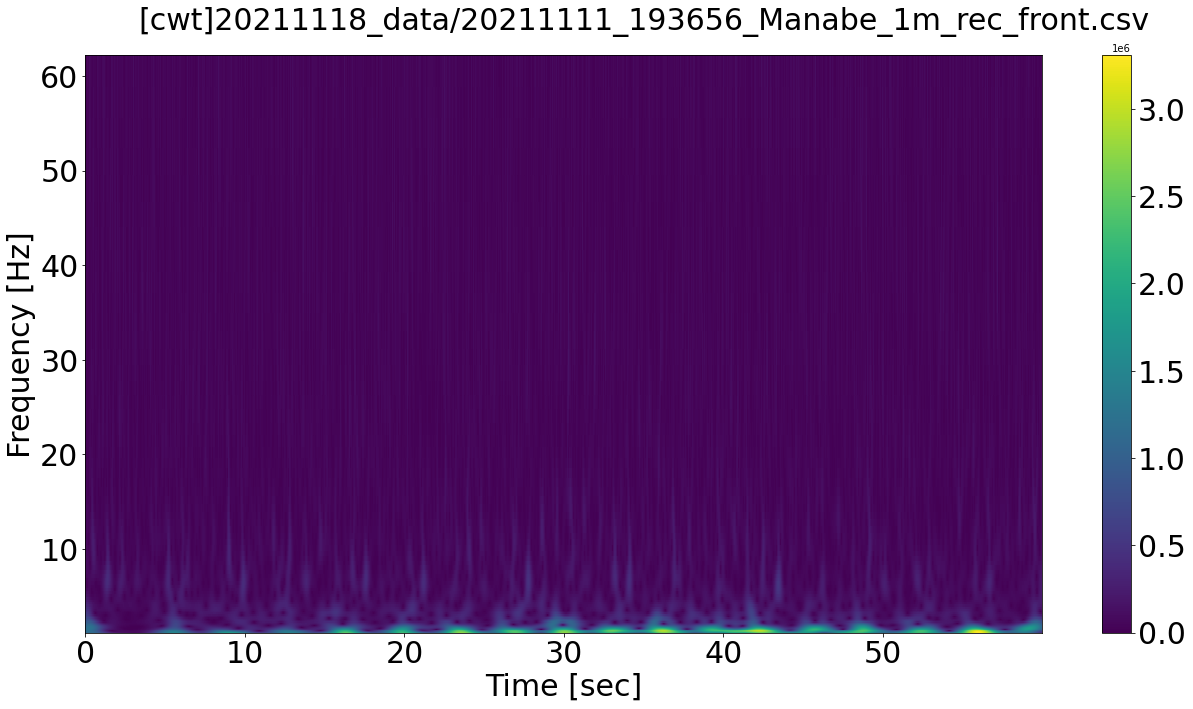

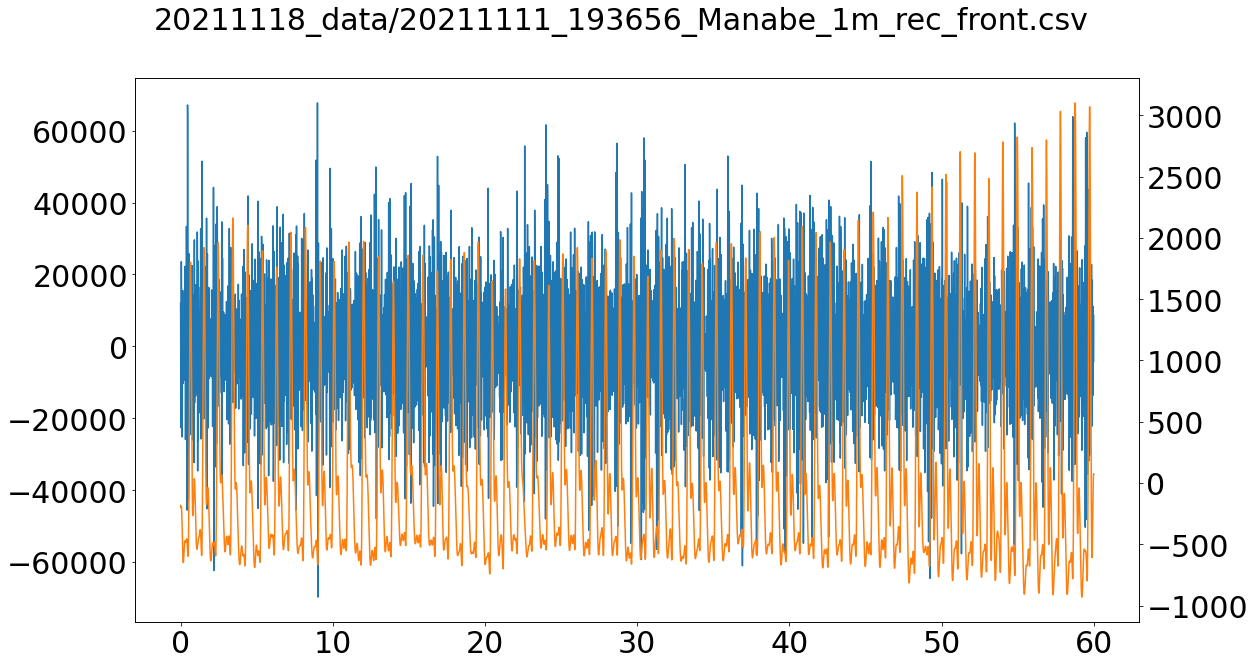

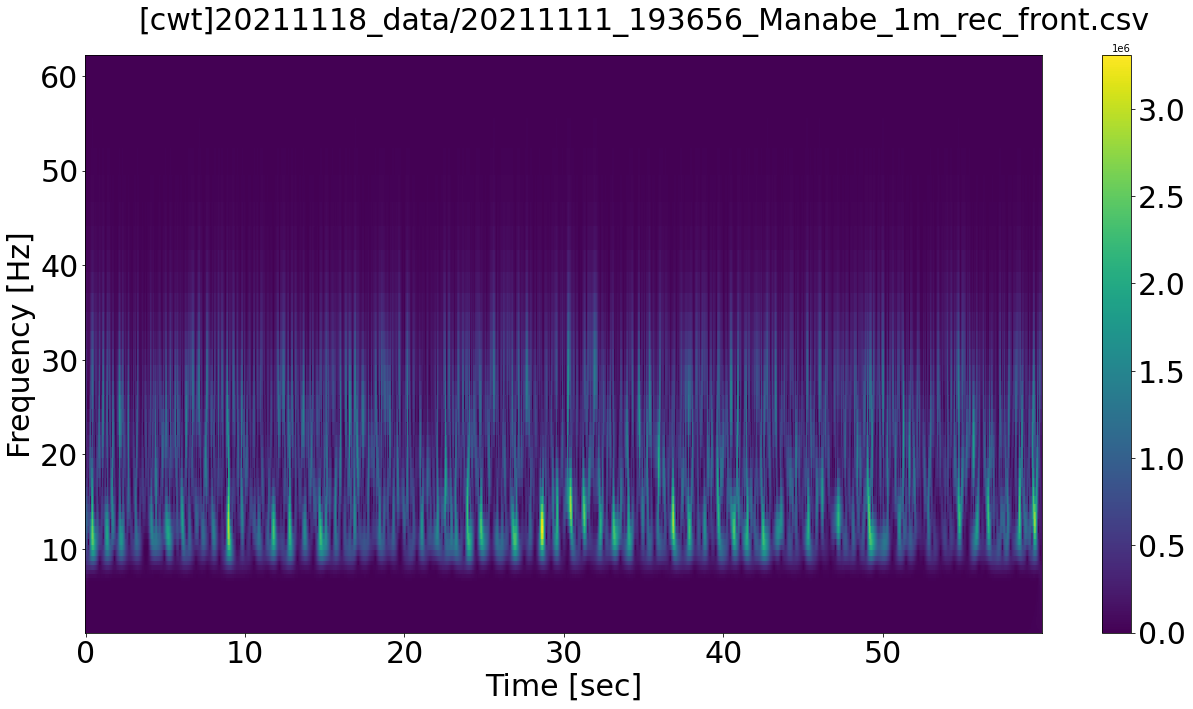

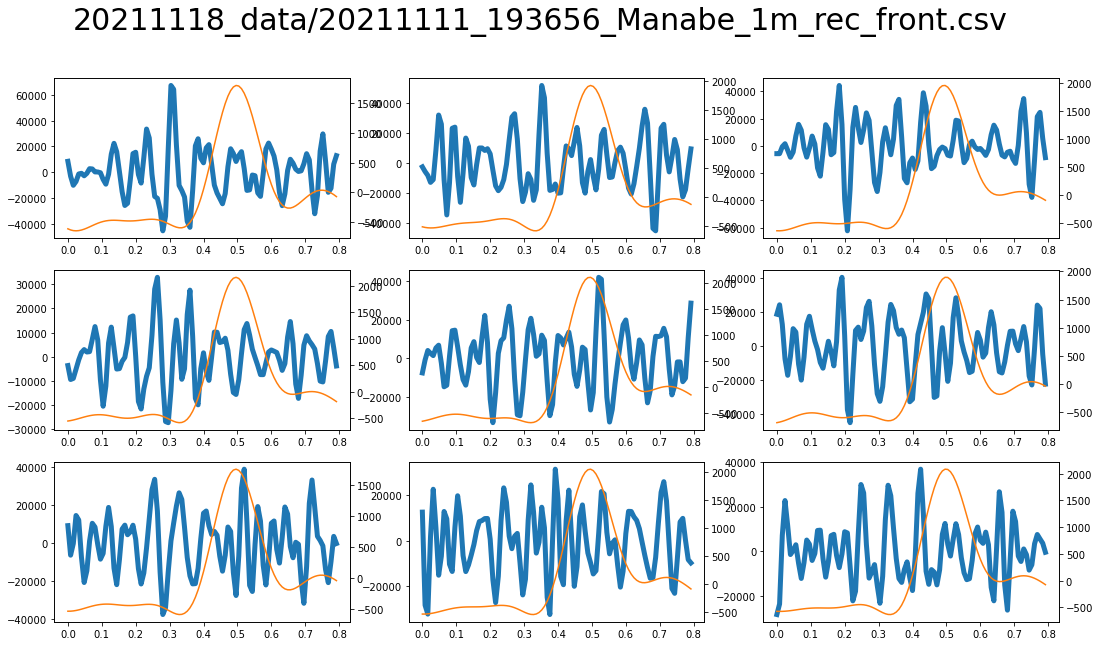

(20, 100)


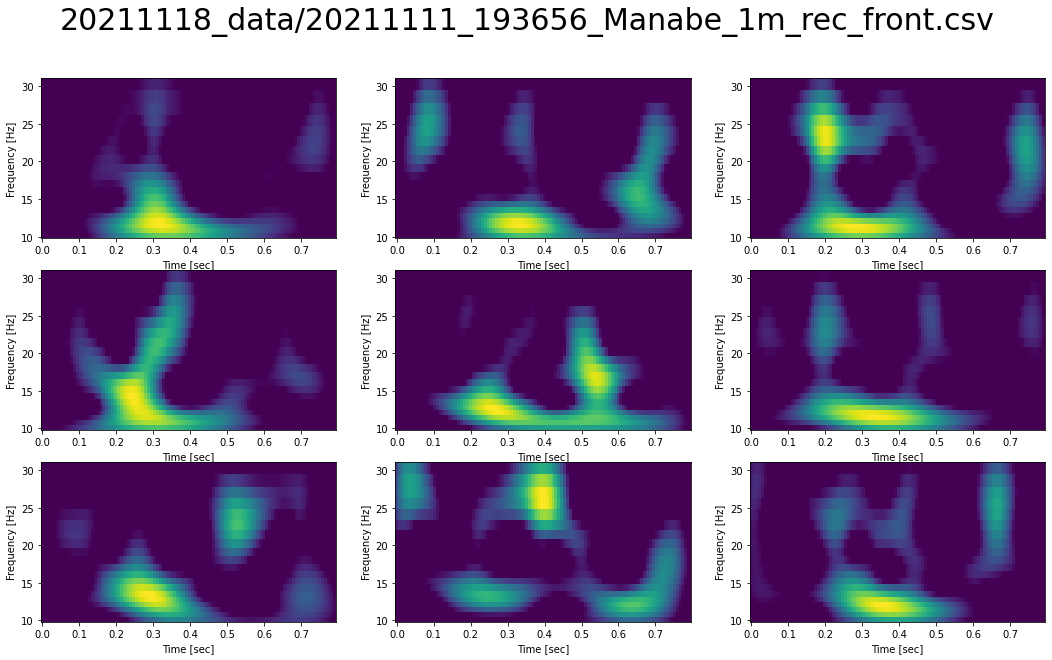

In [20]:
# パラメータ
fs = 125
lpf_fp = 30
lpf_fs = 32
hpf_fp = 10
hpf_fs = 8
thinning_num = 4

dt = 1/fs
pre_sec = 0.5
post_sec = 0.3
pre_sample_num = int(pre_sec*fs)
post_sample_num = int(post_sec*fs)+1
N = pre_sample_num + post_sample_num # サンプル点数
#time_array = np.arange(0,N)*dt # グラフ横軸（時間）

mother = pycwt.Morlet(6)
s0 = 2*dt # ウェーブレットの最小スケール。デフォルト値2dt。
dj = 1/12 # 離散スケールの間隔。デフォルト値1/12。
J =(math.log2(N * dt / s0))/dj # スケールの範囲s0からs0*2**(J*dj)までで、計(J+1)の尺度。
print(J)

cmap = plt.cm.viridis

# --------------------------------------------------------------------------------------- #

filelist = ['20211118_data/20211111_192254_Manabe_50cm_rec_front.csv,500,-1',
            '20211118_data/20211111_193029_Manabe_50cm_rec_front.csv,500,-1',
            '20211118_data/20211111_193354_Manabe_75cm_rec_front.csv,500,-1',
            '20211118_data/20211111_193656_Manabe_1m_rec_front.csv,500,-1',
            # '20211110_235009_hall_bluetooth.csv,500,-1' # 廊下　Bluetooth
            ]

# ファイル読み込み
for idx, filename in enumerate(filelist):
    split_fpdata = filename.rstrip('\r\n').split(',')
    fname = split_fpdata[0]
    #fname = '../'+fname
    wave_fp = codecs.open(fname, 'r')

# ----- csvから2次元listへ
    times = []
    ch = []
    for i in range(7):
        ch.append([])
    for idx2, line in enumerate(wave_fp):
        split_data = line.rstrip('\r\n').split(',')
        times.append(idx2)
        for i in range(7):
            ch[i].append(int(float(split_data[i])))
    wave_fp.close()

# ----- フィルタ前プロット
    i_1st = ch[1]
    i_2nd = ch[2]
    q_1st = ch[3]
    q_2nd = ch[4]
    iq_diff_1st = [i-q for (i,q) in zip(i_1st, q_1st)]
    iq_diff_2nd = [i-q for (i,q) in zip(i_2nd, q_2nd)]
    
    fig = plt.figure(figsize=(18,10))

    doppler = iq_diff_2nd[500:30500]
    ppg = ch[0][500:30500]
    time_array = np.arange(0,len(ppg))/500 # グラフ横軸（時間）

    ax1 = fig.add_subplot(111)
    ax1.plot(time_array,doppler,color='tab:blue')
    plt.tick_params(labelsize=30)
    ax2 = ax1.twinx()
    ax2.plot(time_array,ppg,color='tab:orange')
    plt.tick_params(labelsize=30)
    fig.suptitle(fname, fontsize=30)

    # CWT
    wave, _scales, freqs, _coi, _fft, _fftfreqs = pycwt.cwt(doppler, 1/500, dj, s0, J, mother)
    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(111)
    # ax.pcolormesh(time_array, freqs, sig_proc.zscore(np.abs(wave)), vmin=0, shading='auto')
    pcm = ax.pcolormesh(time_array, freqs, np.abs(wave), vmin=0, shading='auto',cmap=cmap)
    ax.set_ylabel('Frequency [Hz]', fontsize=30)
    ax.set_xlabel('Time [sec]', fontsize=30)
    plt.tick_params(labelsize=30)
    cax = fig.add_axes()
    cbar = plt.colorbar(pcm,orientation='vertical',cax=cax)
    cbar.ax.tick_params(right='off', labelsize=30)
    fig.suptitle('[cwt]'+fname, fontsize=30)
    fig.tight_layout()


    ################################################################################
    #                                フィルタ                                      #
    ################################################################################

    # PPGのフィルタは多分これで確定でよい
    ppg = sig_proc.lpf(ch[0], 500, fp=5, fs=10)[::thinning_num]  # PPG

    i_1st = ch[1]
    i_2nd = ch[2]
    q_1st = ch[3]
    q_2nd = ch[4]
    iq_diff_1st = [i-q for (i,q) in zip(i_1st, q_1st)]
    iq_diff_2nd = [i-q for (i,q) in zip(i_2nd, q_2nd)]

    # フィルタをかける
    i_1st = sig_proc.hpf(sig_proc.lpf(i_1st,500,fp=lpf_fp,fs=lpf_fs),500,fp=hpf_fp,fs=hpf_fs)[::thinning_num]
    i_2nd = sig_proc.hpf(sig_proc.lpf(i_2nd,500,fp=lpf_fp,fs=lpf_fs),500,fp=hpf_fp,fs=hpf_fs)[::thinning_num]
    q_1st = sig_proc.hpf(sig_proc.lpf(q_1st,500,fp=lpf_fp,fs=lpf_fs),500,fp=hpf_fp,fs=hpf_fs)[::thinning_num]
    q_2nd = sig_proc.hpf(sig_proc.lpf(q_2nd,500,fp=lpf_fp,fs=lpf_fs),500,fp=hpf_fp,fs=hpf_fs)[::thinning_num]
    iq_diff_1st = sig_proc.hpf(sig_proc.lpf(iq_diff_1st,500,fp=lpf_fp,fs=lpf_fs),500,fp=hpf_fp,fs=hpf_fs)[::thinning_num]
    iq_diff_2nd = sig_proc.hpf(sig_proc.lpf(iq_diff_2nd,500,fp=lpf_fp,fs=lpf_fs),500,fp=hpf_fp,fs=hpf_fs)[::thinning_num]

    # 呼吸ありデータ
    X_LIM_MIN = int(split_fpdata[1])/thinning_num
    X_LIM_MIN = int(X_LIM_MIN)
    X_LIM_MAX = X_LIM_MIN+30000/thinning_num #そこから60sは通常の呼吸
    X_LIM_MAX = int(X_LIM_MAX)

    chnp = [] 
    chnp.append(np.array(ppg)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(i_1st)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(i_2nd)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(q_1st)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(q_2nd)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(iq_diff_1st)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(iq_diff_2nd)[X_LIM_MIN:X_LIM_MAX])
    data_b = np.vstack([chnp[0], chnp[1], chnp[2], chnp[3], chnp[4], chnp[5], chnp[6]]) # 必要になればこれファイル出力すればOK
    

    # 呼吸なしデータ
    if int(split_fpdata[2]) == -1:
        X_LIM_MAX = -1
    else:
        X_LIM_MAX = int(split_fpdata[2])/thinning_num
        X_LIM_MAX = int(X_LIM_MAX)
    X_LIM_MIN = X_LIM_MAX - 5000/thinning_num
    X_LIM_MIN = int(X_LIM_MIN)

    chnp = []
    chnp.append(np.array(ppg)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(i_1st)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(i_2nd)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(q_1st)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(q_2nd)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(iq_diff_1st)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(iq_diff_2nd)[X_LIM_MIN:X_LIM_MAX])
    data_wob = np.vstack([chnp[0], chnp[1], chnp[2], chnp[3], chnp[4], chnp[5], chnp[6]])

    ################################################################################
    #                                　分割　                                      #
    ################################################################################
    # 一旦、呼吸ありデータだけを対象にして考える
    ppg = data_b[0]
    len_data = data_b.shape[1]

    fig = plt.figure(figsize=(18,10))
    doppler = data_b[6]

    time_array = np.arange(0,ppg.shape[0])*dt # グラフ横軸（時間）

    ax1 = fig.add_subplot(111)
    ax1.plot(time_array,doppler,color='tab:blue')
    plt.tick_params(labelsize=30)
    ax2 = ax1.twinx()
    ax2.plot(time_array,ppg,color='tab:orange')
    plt.tick_params(labelsize=30)
    fig.suptitle(fname, fontsize=30)

    # CWT
    wave, _scales, freqs, _coi, _fft, _fftfreqs = pycwt.cwt(doppler, dt, dj, s0, J, mother)
    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(111)
    # ax.pcolormesh(time_array, freqs, sig_proc.zscore(np.abs(wave)), vmin=0, shading='auto')
    ax.pcolormesh(time_array, freqs, np.abs(wave), vmin=0, shading='auto')
    ax.set_ylabel('Frequency [Hz]', fontsize=30)
    ax.set_xlabel('Time [sec]', fontsize=30)
    plt.tick_params(labelsize=30)
    cax = fig.add_axes()
    cbar = plt.colorbar(pcm,orientation='vertical',cax=cax)
    cbar.ax.tick_params(right='off', labelsize=30)
    fig.suptitle('[cwt]'+fname, fontsize=30)
    fig.tight_layout()
    


# ----- 時系列探索でPPGピーク検出＆分割
    peak_times, peak_vals = sig_proc.peak_search(sig_proc.min_max(ppg), fs)
    # 必要な部分だけ集めたデータdata_dist。あとから一拍ずつ分割。
    data_dist, npeaks, len_per_one, peak_times, peak_vals = peak_detect.data_distribution(data_b, len_data, peak_times, peak_vals, pre_sample_num, post_sample_num)
    
    npeaks = data_dist.shape[0]

    fig = plt.figure(figsize=(18,10))
    
    # 時系列波形
    for peak_idx in range(npeaks):
        if peak_idx >= 9:
            continue

        # 呼吸なしデータ可視化
        doppler_data = data_dist[peak_idx][6]
        ppg_data = data_dist[peak_idx][0]
        time_array = np.arange(0,ppg_data.shape[0])*dt # グラフ横軸（時間）

        ax1 = fig.add_subplot(3,3,peak_idx+1)
        ax1.plot(time_array, doppler_data, color='tab:blue', lw=5)
        ax2 = ax1.twinx()
        ax2.plot(time_array, ppg_data, color='tab:orange')
    #fig.tight_layout()
    fig.suptitle(fname, fontsize=30)
    plt.show()

    # CWT
    fig = plt.figure(figsize=(18,10))
    for peak_idx in range(npeaks):
        if peak_idx >= 9:
            continue

        doppler_data = data_dist[peak_idx][6]
        wave, _scales, freqs, _coi, _fft, _fftfreqs = pycwt.cwt(doppler_data, dt, dj, s0, J, mother)

        wave = wave[12:32,:]
        freqs = freqs[12:32]

        #wave = np.log(wave)
        #wave = sig_proc.min_max(wave) # 0-1正規化
        #wave = zscore(wave)
        
        ax = fig.add_subplot(3,3,peak_idx+1)
        ax.pcolormesh(time_array, freqs, sig_proc.zscore(np.abs(wave)), vmin=0, shading='auto')
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [sec]')
        #ax.set_ylim([3, 50])

    #fig.tight_layout()
    fig.suptitle(fname, fontsize=30)
print(wave.shape)


67.7262742772967


<ipython-input-3-e30ebb5e10e2>:83: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()
<ipython-input-3-e30ebb5e10e2>:179: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


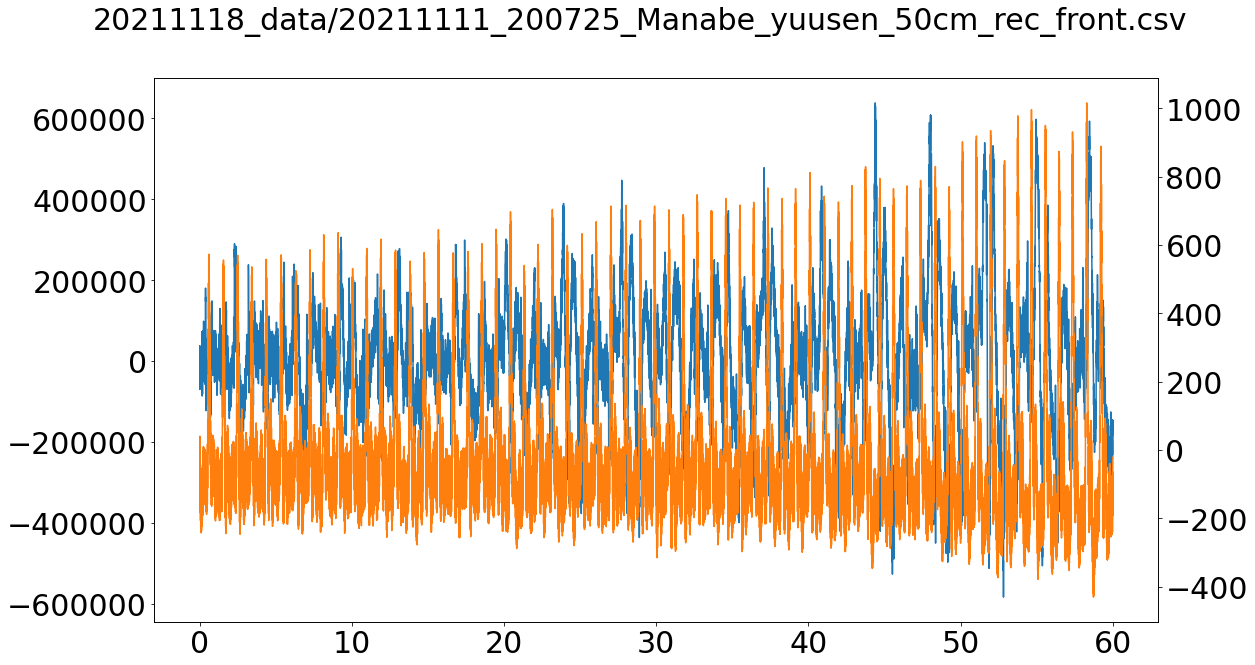

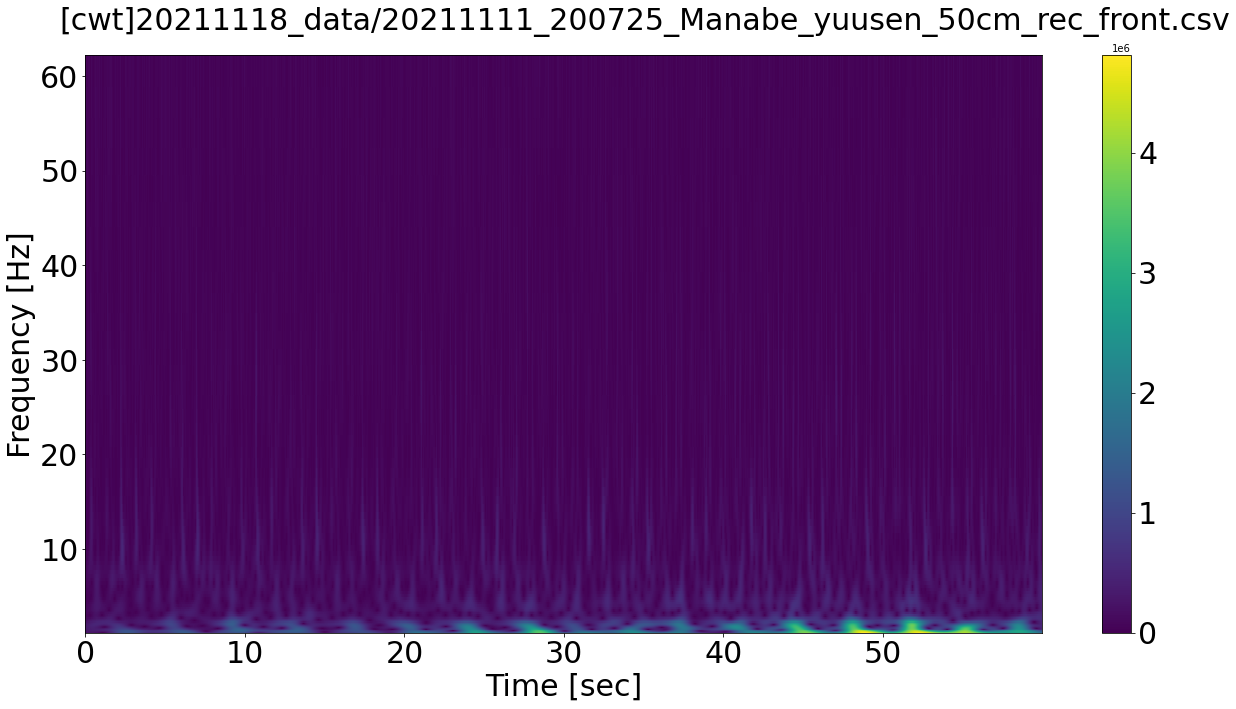

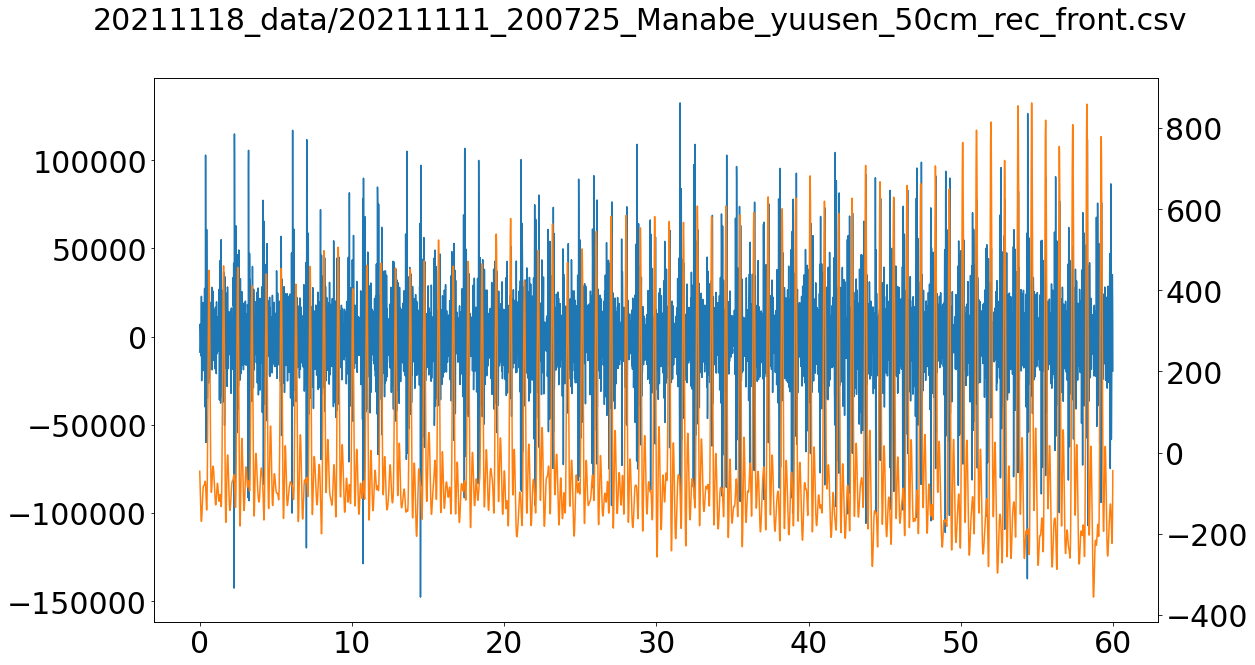

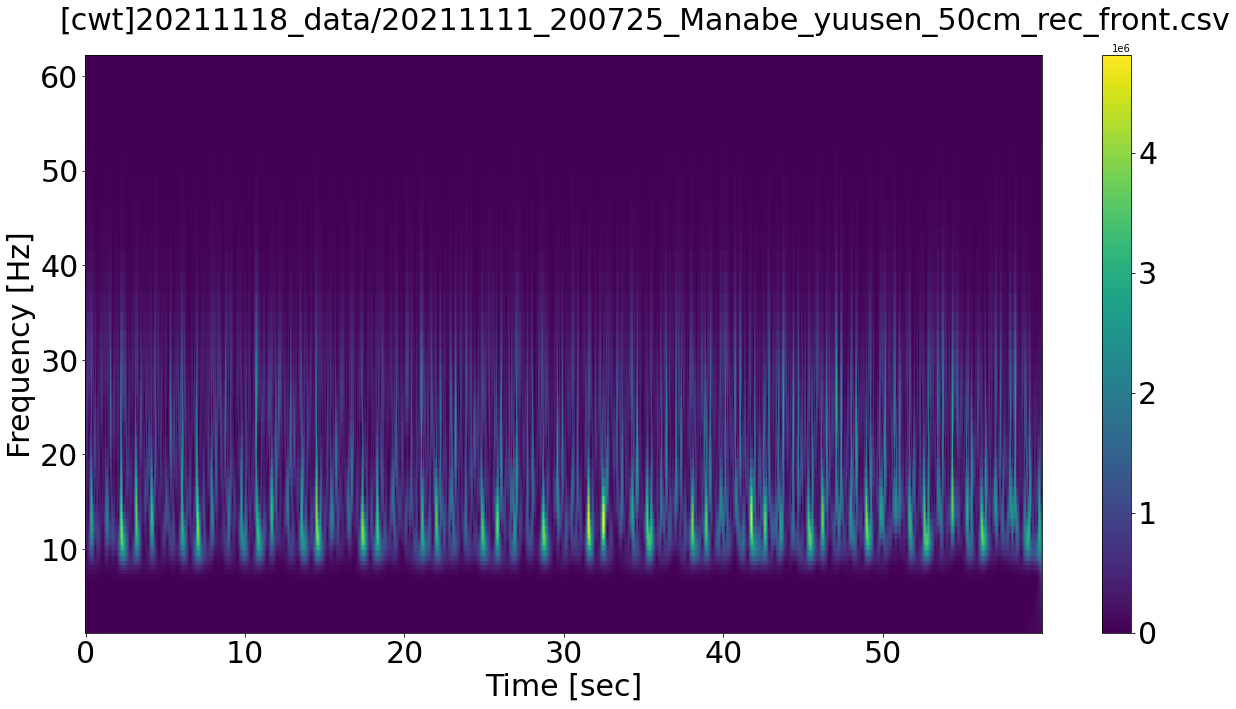

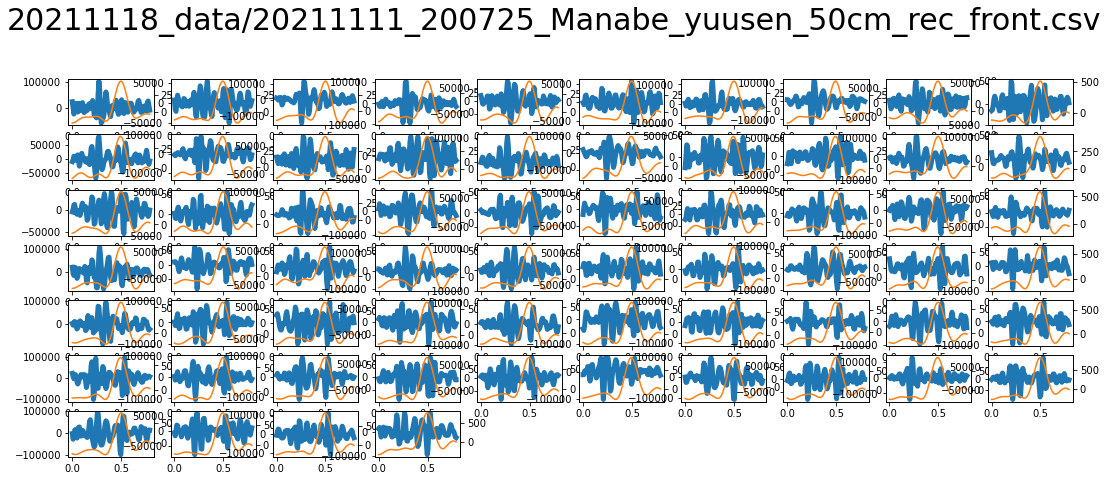

(20, 100)


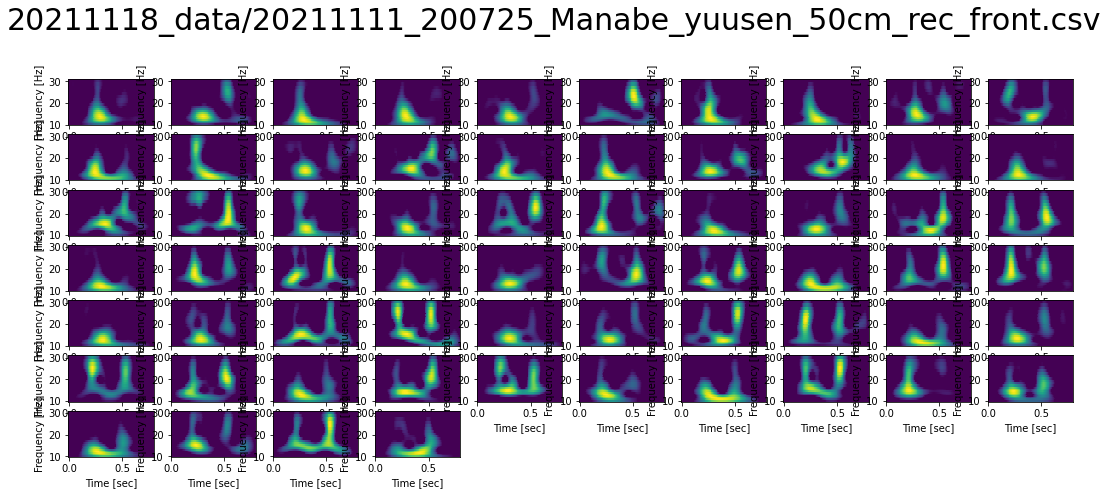

In [3]:
# パラメータ
fs = 125
lpf_fp = 30
lpf_fs = 32
hpf_fp = 10
hpf_fs = 8
thinning_num = 4

dt = 1/fs
pre_sec = 0.5
post_sec = 0.3
pre_sample_num = int(pre_sec*fs)
post_sample_num = int(post_sec*fs)+1
N = pre_sample_num + post_sample_num # サンプル点数
time_array = np.arange(0,N)*dt # グラフ横軸（時間）

mother = pycwt.Morlet(6)
s0 = 2*dt # ウェーブレットの最小スケール。デフォルト値2dt。
dj = 1/12 # 離散スケールの間隔。デフォルト値1/12。
J =(math.log2(N * dt / s0))/dj # スケールの範囲s0からs0*2**(J*dj)までで、計(J+1)の尺度。
print(J)

cmap = plt.cm.viridis

# --------------------------------------------------------------------------------------- #

filelist = ['20211118_data/20211111_200725_Manabe_yuusen_50cm_rec_front.csv,500,-1',
            #'20211118_data/db20211111_195816.csv,500,-1' # 廊下　Bluetooth
            ]

# ファイル読み込み
for idx, filename in enumerate(filelist):
    split_fpdata = filename.rstrip('\r\n').split(',')
    fname = split_fpdata[0]
    #fname = '../'+fname
    wave_fp = codecs.open(fname, 'r')

# ----- csvから2次元listへ
    times = []
    ch = []
    for i in range(7):
        ch.append([])
    for idx2, line in enumerate(wave_fp):
        split_data = line.rstrip('\r\n').split(',')
        times.append(idx2)
        for i in range(7):
            ch[i].append(int(float(split_data[i])))
    wave_fp.close()

# ----- フィルタ前プロット
    i_1st = ch[1]
    i_2nd = ch[2]
    q_1st = ch[3]
    q_2nd = ch[4]
    iq_diff_1st = [i-q for (i,q) in zip(i_1st, q_1st)]
    iq_diff_2nd = [i-q for (i,q) in zip(i_2nd, q_2nd)]
    
    fig = plt.figure(figsize=(18,10))

    doppler = iq_diff_2nd[500:30500]
    ppg = ch[0][500:30500]
    # doppler = iq_diff_2nd[30000:35000]
    # ppg = ch[0][30000:35000]
    time_array = np.arange(0,len(ppg))/500 # グラフ横軸（時間）

    ax1 = fig.add_subplot(111)
    ax1.plot(time_array,doppler,color='tab:blue')
    plt.tick_params(labelsize=30)
    ax2 = ax1.twinx()
    ax2.plot(time_array,ppg,color='tab:orange')
    plt.tick_params(labelsize=30)
    fig.suptitle(fname, fontsize=30)

    # CWT
    wave, _scales, freqs, _coi, _fft, _fftfreqs = pycwt.cwt(doppler, 1/500, dj, s0, J, mother)
    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(111)
    # ax.pcolormesh(time_array, freqs, sig_proc.zscore(np.abs(wave)), vmin=0, shading='auto')
    pcm = ax.pcolormesh(time_array, freqs, np.abs(wave), vmin=0, shading='auto',cmap=cmap)
    ax.set_ylabel('Frequency [Hz]', fontsize=30)
    ax.set_xlabel('Time [sec]', fontsize=30)
    plt.tick_params(labelsize=30)
    cax = fig.add_axes()
    cbar = plt.colorbar(pcm,orientation='vertical',cax=cax)
    cbar.ax.tick_params(right='off', labelsize=30)
    fig.suptitle('[cwt]'+fname, fontsize=30)
    fig.tight_layout()


    ################################################################################
    #                                フィルタ                                      #
    ################################################################################

    # PPGのフィルタは多分これで確定でよい
    ppg = sig_proc.lpf(ch[0], 500, fp=5, fs=10)[::thinning_num]  # PPG

    i_1st = ch[1]
    i_2nd = ch[2]
    q_1st = ch[3]
    q_2nd = ch[4]
    iq_diff_1st = [i-q for (i,q) in zip(i_1st, q_1st)]
    iq_diff_2nd = [i-q for (i,q) in zip(i_2nd, q_2nd)]

    # フィルタをかける
    i_1st = sig_proc.hpf(sig_proc.lpf(i_1st,500,fp=lpf_fp,fs=lpf_fs),500,fp=hpf_fp,fs=hpf_fs)[::thinning_num]
    i_2nd = sig_proc.hpf(sig_proc.lpf(i_2nd,500,fp=lpf_fp,fs=lpf_fs),500,fp=hpf_fp,fs=hpf_fs)[::thinning_num]
    q_1st = sig_proc.hpf(sig_proc.lpf(q_1st,500,fp=lpf_fp,fs=lpf_fs),500,fp=hpf_fp,fs=hpf_fs)[::thinning_num]
    q_2nd = sig_proc.hpf(sig_proc.lpf(q_2nd,500,fp=lpf_fp,fs=lpf_fs),500,fp=hpf_fp,fs=hpf_fs)[::thinning_num]
    iq_diff_1st = sig_proc.hpf(sig_proc.lpf(iq_diff_1st,500,fp=lpf_fp,fs=lpf_fs),500,fp=hpf_fp,fs=hpf_fs)[::thinning_num]
    iq_diff_2nd = sig_proc.hpf(sig_proc.lpf(iq_diff_2nd,500,fp=lpf_fp,fs=lpf_fs),500,fp=hpf_fp,fs=hpf_fs)[::thinning_num]

    # 呼吸ありデータ
    X_LIM_MIN = int(split_fpdata[1])/thinning_num
    X_LIM_MIN = int(X_LIM_MIN)
    
    X_LIM_MAX = X_LIM_MIN+30000/thinning_num #そこから60sは通常の呼吸
    # X_LIM_MAX = X_LIM_MIN+5000/thinning_num #そこから60sは通常の呼吸
    X_LIM_MAX = int(X_LIM_MAX)

    chnp = [] 
    chnp.append(np.array(ppg)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(i_1st)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(i_2nd)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(q_1st)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(q_2nd)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(iq_diff_1st)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(iq_diff_2nd)[X_LIM_MIN:X_LIM_MAX])
    data_b = np.vstack([chnp[0], chnp[1], chnp[2], chnp[3], chnp[4], chnp[5], chnp[6]]) # 必要になればこれファイル出力すればOK
    

    # 呼吸なしデータ
    if int(split_fpdata[2]) == -1:
        X_LIM_MAX = -1
    else:
        X_LIM_MAX = int(split_fpdata[2])/thinning_num
        X_LIM_MAX = int(X_LIM_MAX)
    X_LIM_MIN = X_LIM_MAX - 5000/thinning_num
    X_LIM_MIN = int(X_LIM_MIN)

    chnp = []
    chnp.append(np.array(ppg)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(i_1st)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(i_2nd)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(q_1st)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(q_2nd)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(iq_diff_1st)[X_LIM_MIN:X_LIM_MAX])
    chnp.append(np.array(iq_diff_2nd)[X_LIM_MIN:X_LIM_MAX])
    data_wob = np.vstack([chnp[0], chnp[1], chnp[2], chnp[3], chnp[4], chnp[5], chnp[6]])

    ################################################################################
    #                                　分割　                                      #
    ################################################################################
    # 一旦、呼吸ありデータだけを対象にして考える
    ppg = data_b[0]
    len_data = data_b.shape[1]

    fig = plt.figure(figsize=(18,10))
    doppler = data_b[6]

    time_array = np.arange(0,ppg.shape[0])*dt # グラフ横軸（時間）

    ax1 = fig.add_subplot(111)
    ax1.plot(time_array,doppler,color='tab:blue')
    plt.tick_params(labelsize=30)
    ax2 = ax1.twinx()
    ax2.plot(time_array,ppg,color='tab:orange')
    plt.tick_params(labelsize=30)
    fig.suptitle(fname, fontsize=30)

    # CWT
    wave, _scales, freqs, _coi, _fft, _fftfreqs = pycwt.cwt(doppler, dt, dj, s0, J, mother)
    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(111)
    # ax.pcolormesh(time_array, freqs, sig_proc.zscore(np.abs(wave)), vmin=0, shading='auto')
    ax.pcolormesh(time_array, freqs, np.abs(wave), vmin=0, shading='auto')
    ax.set_ylabel('Frequency [Hz]', fontsize=30)
    ax.set_xlabel('Time [sec]', fontsize=30)
    plt.tick_params(labelsize=30)
    cax = fig.add_axes()
    cbar = plt.colorbar(pcm,orientation='vertical',cax=cax)
    cbar.ax.tick_params(right='off', labelsize=30)
    fig.suptitle('[cwt]'+fname, fontsize=30)
    fig.tight_layout()
    


# ----- 時系列探索でPPGピーク検出＆分割
    peak_times, peak_vals = sig_proc.peak_search(sig_proc.min_max(ppg), fs)
    # 必要な部分だけ集めたデータdata_dist。あとから一拍ずつ分割。
    data_dist, npeaks, len_per_one, peak_times, peak_vals = peak_detect.data_distribution(data_b, len_data, peak_times, peak_vals, pre_sample_num, post_sample_num)
    
    npeaks = data_dist.shape[0]

    fig = plt.figure(figsize=(18,10))
    
    # 時系列波形
    for peak_idx in range(npeaks):
        # if peak_idx >= 9:
        #     continue

        # 呼吸なしデータ可視化
        doppler_data = data_dist[peak_idx][6]
        ppg_data = data_dist[peak_idx][0]
        time_array = np.arange(0,ppg_data.shape[0])*dt # グラフ横軸（時間）

        ax1 = fig.add_subplot(10,10,peak_idx+1)
        ax1.plot(time_array, doppler_data, color='tab:blue', lw=5)
        ax2 = ax1.twinx()
        ax2.plot(time_array, ppg_data, color='tab:orange')
    #fig.tight_layout()
    fig.suptitle(fname, fontsize=30)
    plt.show()

    # CWT
    fig = plt.figure(figsize=(18,10))
    for peak_idx in range(npeaks):
        # if peak_idx >= 9:
        #     continue

        doppler_data = data_dist[peak_idx][6]
        wave, _scales, freqs, _coi, _fft, _fftfreqs = pycwt.cwt(doppler_data, dt, dj, s0, J, mother)

        wave = wave[12:32,:]
        freqs = freqs[12:32]

        #wave = np.log(wave)
        #wave = sig_proc.min_max(wave) # 0-1正規化
        #wave = zscore(wave)
        
        ax = fig.add_subplot(10,10,peak_idx+1)
        ax.pcolormesh(time_array, freqs, sig_proc.zscore(np.abs(wave)), vmin=0, shading='auto')
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [sec]')
        #ax.set_ylim([3, 50])

    #fig.tight_layout()
    fig.suptitle(fname, fontsize=30)
print(wave.shape)


## ↑　有線の60秒間プロット
***

67.7262742772967


<ipython-input-4-24240670e50c>:81: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()
<ipython-input-4-24240670e50c>:118: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


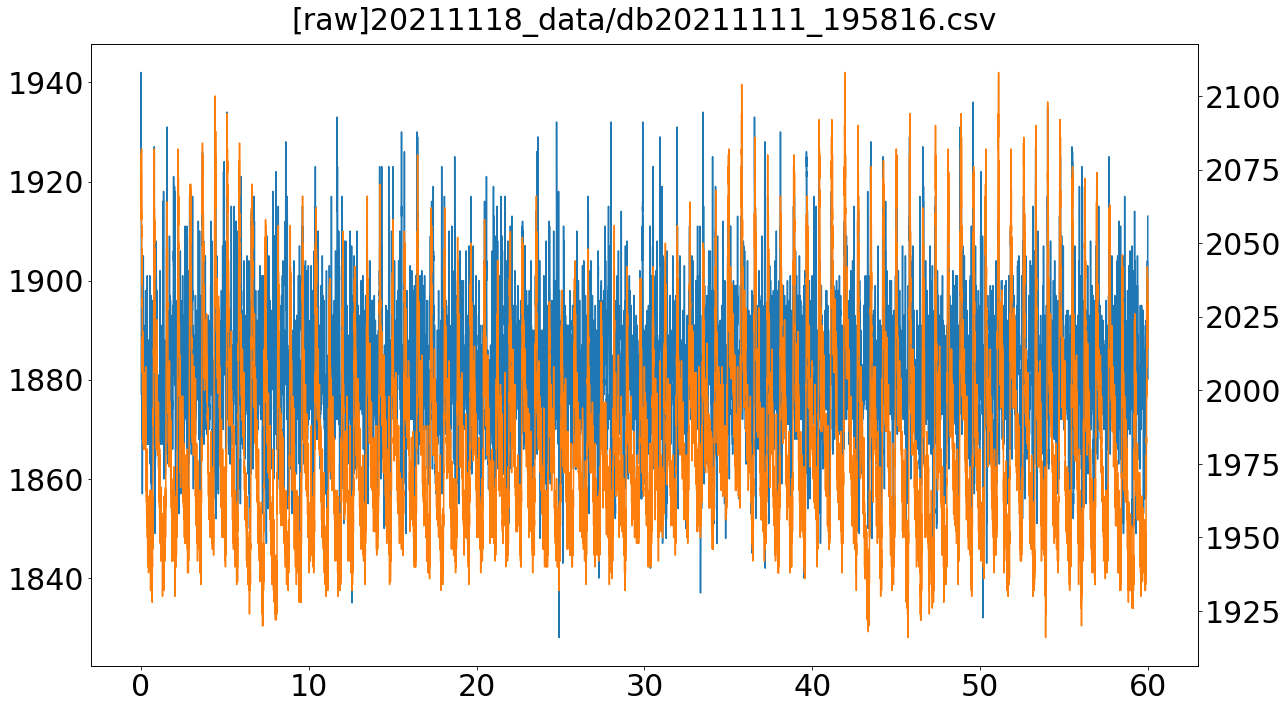

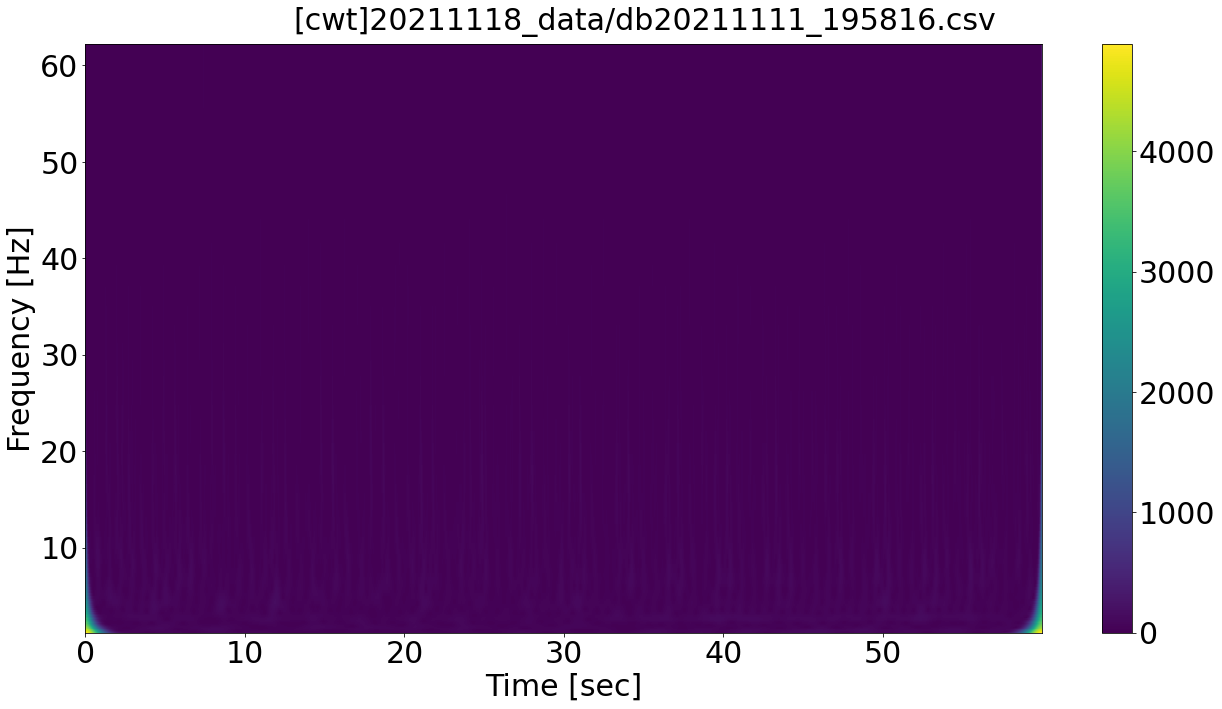

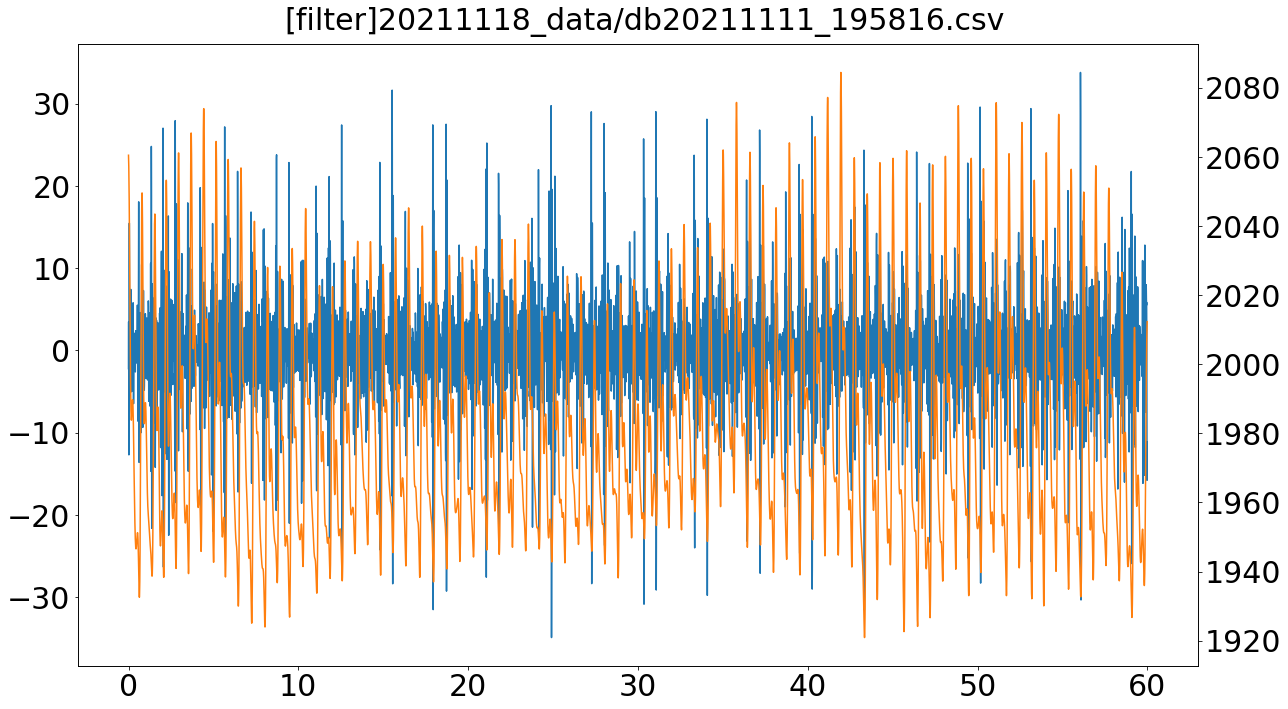

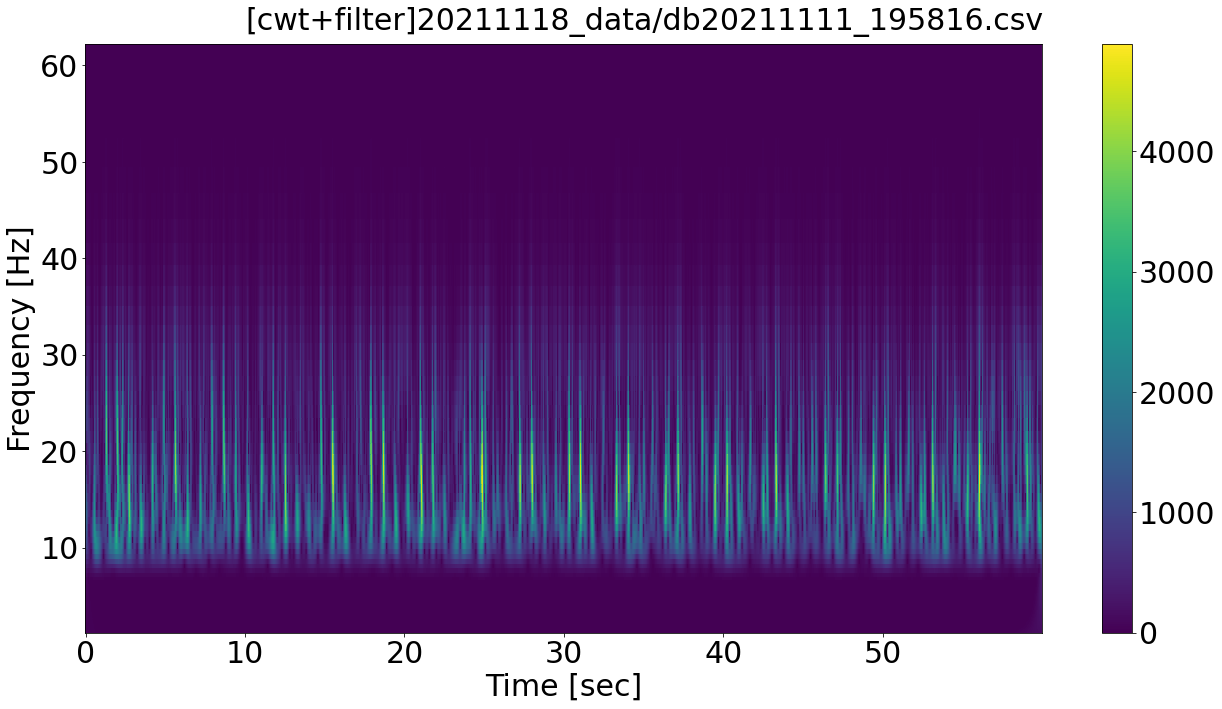

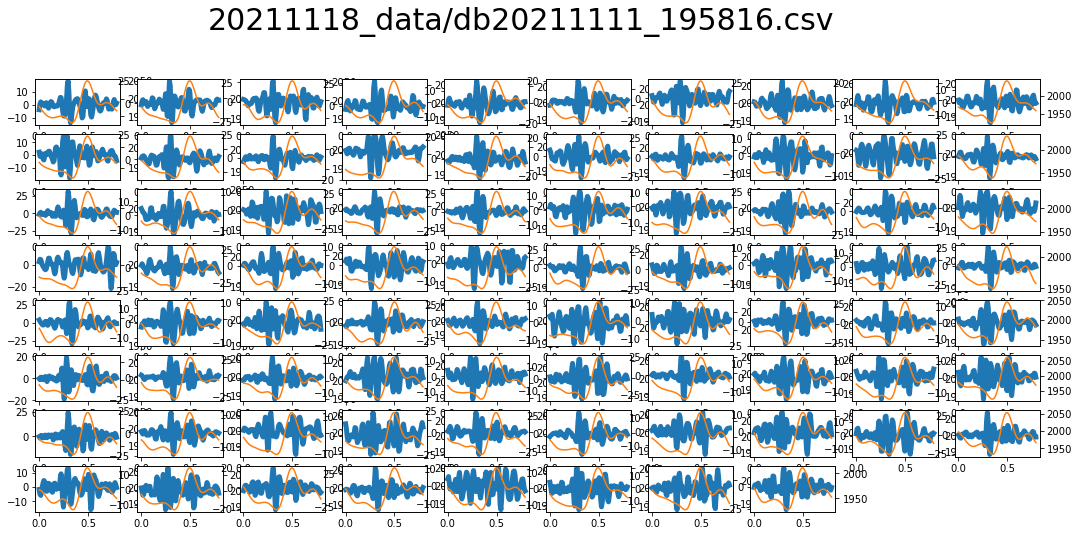

(20, 100)


"    # CWT\n    wave, _scales, freqs, _coi, _fft, _fftfreqs = pycwt.cwt(doppler, 1/500, dj, s0, J, mother)\n    fig = plt.figure(figsize=(18,10))\n    ax = fig.add_subplot(111)\n    # ax.pcolormesh(time_array, freqs, sig_proc.zscore(np.abs(wave)), vmin=0, shading='auto')\n    pcm = ax.pcolormesh(time_array, freqs, np.abs(wave), vmin=0, shading='auto',cmap=cmap)\n    ax.set_ylabel('Frequency [Hz]', fontsize=30)\n    ax.set_xlabel('Time [sec]', fontsize=30)\n    plt.tick_params(labelsize=30)\n    cax = fig.add_axes()\n    cbar = plt.colorbar(pcm,orientation='vertical',cax=cax)\n    cbar.ax.tick_params(right='off', labelsize=30)\n    fig.suptitle('[cwt]'+fname, fontsize=30)\n    fig.tight_layout()"

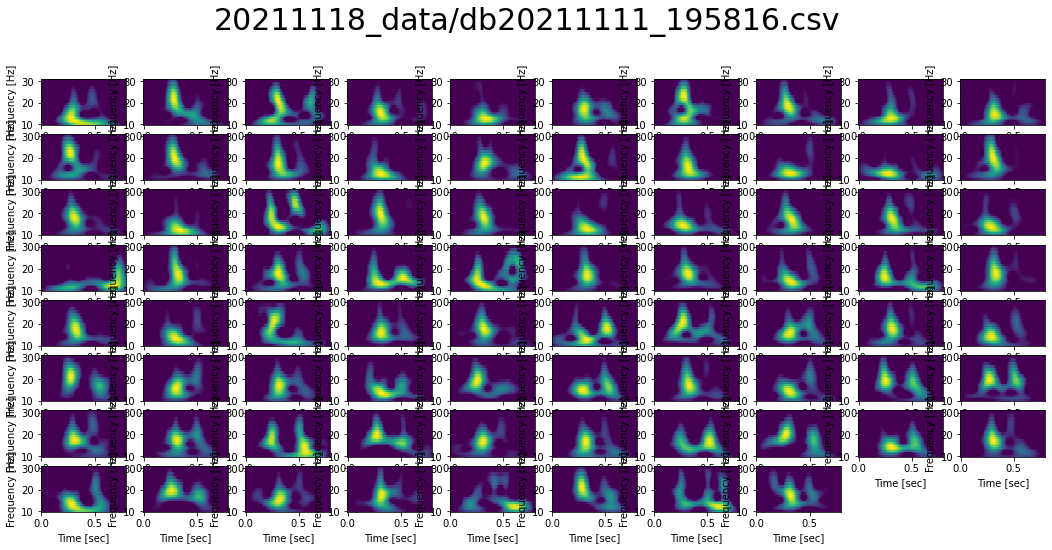

In [4]:
# パラメータ
fs = 125
lpf_fp = 30
lpf_fs = 32
hpf_fp = 10
hpf_fs = 8
thinning_num = 4

dt = 1/fs
pre_sec = 0.5
post_sec = 0.3
pre_sample_num = int(pre_sec*fs)
post_sample_num = int(post_sec*fs)+1
N = pre_sample_num + post_sample_num # サンプル点数
time_array = np.arange(0,N)*dt # グラフ横軸（時間）

mother = pycwt.Morlet(6)
s0 = 2*dt # ウェーブレットの最小スケール。デフォルト値2dt。
dj = 1/12 # 離散スケールの間隔。デフォルト値1/12。
J =(math.log2(N * dt / s0))/dj # スケールの範囲s0からs0*2**(J*dj)までで、計(J+1)の尺度。
print(J)

cmap = plt.cm.viridis

# --------------------------------------------------------------------------------------- #

filelist = [#'20211118_data/20211111_200725_Manabe_yuusen_50cm_rec_front.csv,500,-1',
            '20211118_data/db20211111_195816.csv,500,-1' # 廊下　Bluetooth
            ]

# ファイル読み込み
for idx, filename in enumerate(filelist):
    split_fpdata = filename.rstrip('\r\n').split(',')
    fname = split_fpdata[0]
    #fname = '../'+fname
    wave_fp = codecs.open(fname, 'r')

# ----- csvから2次元listへ
    times = []
    ch = []
    for i in range(2):
        ch.append([])
    for idx2, line in enumerate(wave_fp):
        split_data = line.rstrip('\r\n').split(',')
        times.append(idx2)
        for i in range(2):
            ch[i].append(int(float(split_data[i])))
    wave_fp.close()

# ----- フィルタ前プロット
    ppg = ch[0][30000:60000]
    doppler = ch[1][30000:60000]
    # ppg = ch[0][30000:35000]
    # doppler = ch[1][30000:35000]
    
    fig = plt.figure(figsize=(18,10))

    
    time_array = np.arange(0,len(doppler))/500 # グラフ横軸（時間）

    ax1 = fig.add_subplot(111)
    ax1.plot(time_array,doppler,color='tab:blue')
    plt.tick_params(labelsize=30)
    ax2 = ax1.twinx()
    ax2.plot(time_array,ppg,color='tab:orange')
    fig.suptitle('[raw]'+fname, fontsize=30)
    plt.tick_params(labelsize=30)
    fig.suptitle('[raw]'+fname, fontsize=30)

    fig.tight_layout()

    # CWT
    wave, _scales, freqs, _coi, _fft, _fftfreqs = pycwt.cwt(doppler, 1/500, dj, s0, J, mother)
    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(111)
    # ax.pcolormesh(time_array, freqs, sig_proc.zscore(np.abs(wave)), vmin=0, shading='auto')
    pcm = ax.pcolormesh(time_array, freqs, np.abs(wave), vmin=0, shading='auto',cmap=cmap)
    ax.set_ylabel('Frequency [Hz]', fontsize=30)
    ax.set_xlabel('Time [sec]', fontsize=30)
    plt.tick_params(labelsize=30)
    cax = fig.add_axes()
    cbar = plt.colorbar(pcm,orientation='vertical',cax=cax)
    cbar.ax.tick_params(right='off', labelsize=30)
    fig.suptitle('[cwt]'+fname, fontsize=30)
    fig.tight_layout()


    ################################################################################
    #                                フィルタ                                      #
    ################################################################################

    # フィルタをかける
    # PPGのフィルタは多分これで確定でよい
    ppg = sig_proc.lpf(ppg, 500, fp=5, fs=10)[::thinning_num]  # PPG
    doppler = sig_proc.hpf(sig_proc.lpf(doppler,500,fp=lpf_fp,fs=lpf_fs),500,fp=hpf_fp,fs=hpf_fs)[::thinning_num]

    fig = plt.figure(figsize=(18,10))
    time_array = np.arange(0,doppler.shape[0])*dt # グラフ横軸（時間）

    ax1 = fig.add_subplot(111)
    ax1.plot(time_array,doppler,color='tab:blue')
    plt.tick_params(labelsize=30)
    ax2 = ax1.twinx()
    ax2.plot(time_array,ppg,color='tab:orange')
    plt.tick_params(labelsize=30)
    fig.suptitle('[filter]'+fname, fontsize=30)
    fig.tight_layout()

    # CWT
    wave, _scales, freqs, _coi, _fft, _fftfreqs = pycwt.cwt(doppler, dt, dj, s0, J, mother)
    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(111)
    # ax.pcolormesh(time_array, freqs, sig_proc.zscore(np.abs(wave)), vmin=0, shading='auto')
    ax.pcolormesh(time_array, freqs, np.abs(wave), vmin=0, shading='auto')
    ax.set_ylabel('Frequency [Hz]', fontsize=30)
    ax.set_xlabel('Time [sec]', fontsize=30)
    plt.tick_params(labelsize=30)
    cax = fig.add_axes()
    cbar = plt.colorbar(pcm,orientation='vertical',cax=cax)
    cbar.ax.tick_params(right='off', labelsize=30)
    fig.suptitle('[cwt+filter]'+fname, fontsize=30)
    fig.tight_layout()
    


# ----- 時系列探索でPPGピーク検出＆分割
    # まじで意味ないけど必要なコード　データ分割関数にぶち込むためには形式を7行にするしかないんだ......
    chnp = [] 
    chnp.append(np.array(ppg))
    chnp.append(np.zeros_like(ppg))
    chnp.append(np.zeros_like(ppg))
    chnp.append(np.zeros_like(ppg))
    chnp.append(np.zeros_like(ppg))
    chnp.append(np.zeros_like(ppg))
    chnp.append(np.array(doppler))
    data_b = np.vstack([chnp[0], chnp[1], chnp[2], chnp[3], chnp[4], chnp[5], chnp[6]]) # 必要になればこれファイル出力すればOK

    peak_times, peak_vals = sig_proc.peak_search(sig_proc.min_max(ppg), fs)
    # 必要な部分だけ集めたデータdata_dist。あとから一拍ずつ分割。
    data_dist, npeaks, len_per_one, peak_times, peak_vals = peak_detect.data_distribution(data_b, len_data, peak_times, peak_vals, pre_sample_num, post_sample_num)
    
    npeaks = data_dist.shape[0]

    fig = plt.figure(figsize=(18,10))
    
    # 時系列波形
    for peak_idx in range(npeaks):
        # if peak_idx >= 9:
        #     continue

        # 呼吸なしデータ可視化
        doppler_data = data_dist[peak_idx][6]
        ppg_data = data_dist[peak_idx][0]
        time_array = np.arange(0,ppg_data.shape[0])*dt # グラフ横軸（時間）

        ax1 = fig.add_subplot(10,10,peak_idx+1)
        ax1.plot(time_array, doppler_data, color='tab:blue', lw=5)
        ax2 = ax1.twinx()
        ax2.plot(time_array, ppg_data, color='tab:orange')
    #fig.tight_layout()
    fig.suptitle(fname, fontsize=30)
    plt.show()

    # CWT
    fig = plt.figure(figsize=(18,10))
    for peak_idx in range(npeaks):
        # if peak_idx >= 9:
        #     continue

        doppler_data = data_dist[peak_idx][6]
        wave, _scales, freqs, _coi, _fft, _fftfreqs = pycwt.cwt(doppler_data, dt, dj, s0, J, mother)

        wave = wave[12:32,:]
        freqs = freqs[12:32]

        #wave = np.log(wave)
        #wave = sig_proc.min_max(wave) # 0-1正規化
        #wave = zscore(wave)
        
        ax = fig.add_subplot(10,10,peak_idx+1)
        pcm = ax.pcolormesh(time_array, freqs, sig_proc.zscore(np.abs(wave)), vmin=0, shading='auto')
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [sec]')
        #ax.set_ylim([3, 50])

    # cax = fig.add_axes()
    # cax = plt.axes([0.8, 0.1, 0.025, 0.8])
    # cbar = plt.colorbar(pcm,orientation='vertical',cax=cax)
    # cbar.ax.tick_params(right='off', labelsize=30)
    # fig.tight_layout()
    fig.suptitle(fname, fontsize=30)
print(wave.shape)

"""    # CWT
    wave, _scales, freqs, _coi, _fft, _fftfreqs = pycwt.cwt(doppler, 1/500, dj, s0, J, mother)
    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(111)
    # ax.pcolormesh(time_array, freqs, sig_proc.zscore(np.abs(wave)), vmin=0, shading='auto')
    pcm = ax.pcolormesh(time_array, freqs, np.abs(wave), vmin=0, shading='auto',cmap=cmap)
    ax.set_ylabel('Frequency [Hz]', fontsize=30)
    ax.set_xlabel('Time [sec]', fontsize=30)
    plt.tick_params(labelsize=30)
    cax = fig.add_axes()
    cbar = plt.colorbar(pcm,orientation='vertical',cax=cax)
    cbar.ax.tick_params(right='off', labelsize=30)
    fig.suptitle('[cwt]'+fname, fontsize=30)
    fig.tight_layout()"""


## ↑　Bluetoothの60秒間プロット
***